In [1]:
# libraries 
import os  
import seaborn as sns 
import cv2 
import tensorflow as tf  
import matplotlib.pyplot as plt 
import time 
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.utils import shuffle  
from keras.saving import save_model 
import numpy as np 

from sklearn.model_selection import KFold 
from keras.models import Model, load_model 
from tensorflow.keras.applications import Xception, InceptionV3, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [2]:
def visualize(history): 

    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    # Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    return plt.show() 

In [3]:
def visualize_2(history): 
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}' 
    
    # Plot training history
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight') 
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [4]:
labels = ['glioma','meningioma','notumor','pituitary']    

X_train = []
y_train = []
image_size = 299

for i in labels:
    folderPath = os.path.join('./DataSet','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('./DataSet','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 672.63it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101) 

In [6]:
X_train.shape

(6795, 299, 299, 3)

In [7]:
labels = ['glioma','meningioma','notumor','pituitary']     
label_to_index = {labels: index for index, labels in enumerate(labels)}
y_train_indices = np.array([label_to_index[labels] for labels in y_train])

# Convert indices to one-hot encoded vectors
y_train_one_encoded = tf.keras.utils.to_categorical(y_train_indices, num_classes=len(labels))

In [8]:
y_train_one_encoded.shape

(6795, 4)

# -------------------------------------------- Transfer Learning Models -------------------------------------------

##  /////////////////////////////////////////////////////////  Xception  ////////////////////////////////////////////////////////////

In [9]:
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) 

NUM_CLASSES = 4   

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001) 

# Freeze all layers in the base model 
for layer in base_model_Xception.layers:
    layer.trainable = False 
    
# add global average pooling layer
x = base_model_Xception.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)  

# Add dropout layer
x = tf.keras.layers.Dropout(0.5)(x)  # 0.5 is the dropout rate
# output layer
outputlayer_Xception = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)   

#creating new model
model_Xception = tf.keras.Model(inputs=base_model_Xception.input, outputs=outputlayer_Xception) 

# Compile model
model_Xception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   

Fold 1/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5233 - loss: 3.2133 - val_accuracy: 0.8337 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8072 - loss: 0.5445 - val_accuracy: 0.8366 - val_loss: 0.4935 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8395 - loss: 0.4420 - val_accuracy: 0.8521 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8525 - loss: 0.3870 - val_accuracy: 0.8389 - val_loss: 0.3993 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8630 - loss: 0.3587 - val_accuracy: 0.8808 - val_loss: 0.3321 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8888 - loss: 0.3019 - val_accuracy: 0.8911 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8885 - loss: 0.2912 

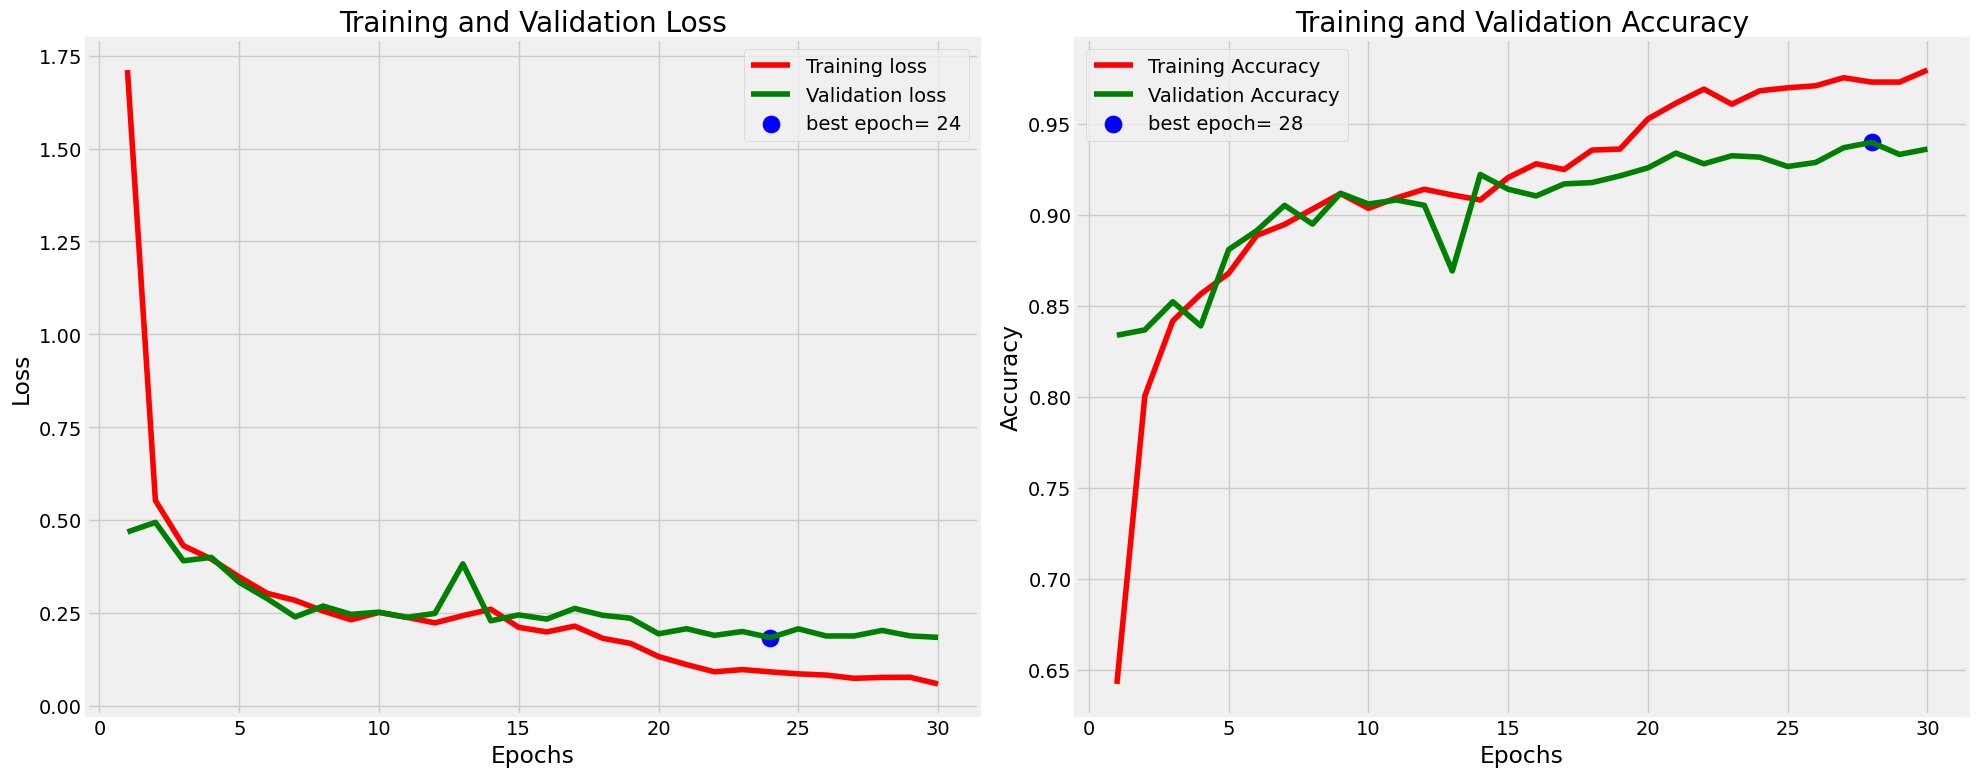

43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 813ms/step
Classification Report for Fold 1
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       332
           1       0.87      0.85      0.86       277
           2       0.98      0.97      0.98       401
           3       0.97      0.98      0.97       349

    accuracy                           0.93      1359
   macro avg       0.93      0.93      0.93      1359
weighted avg       0.93      0.93      0.93      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 805ms/step


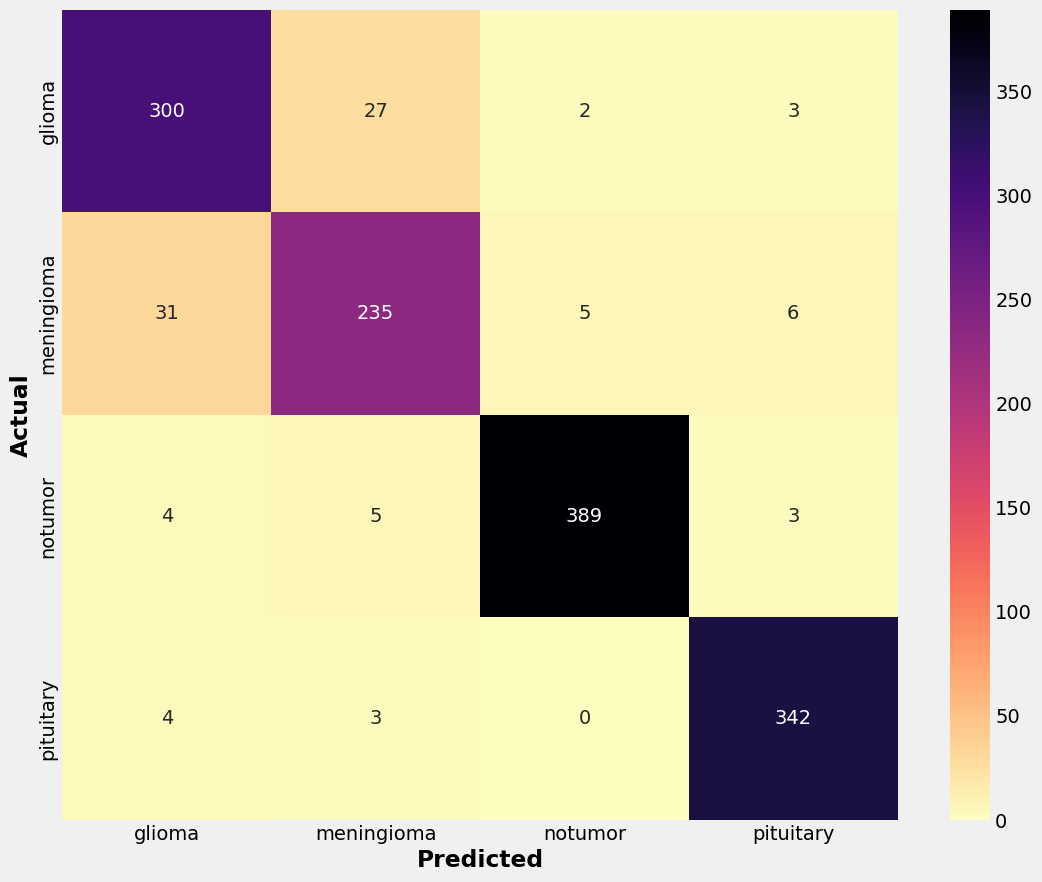

Fold 2/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9615 - loss: 0.1117 - val_accuracy: 0.9868 - val_loss: 0.0565 - learning_rate: 2.5000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9632 - loss: 0.1099 - val_accuracy: 0.9882 - val_loss: 0.0515 - learning_rate: 2.5000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9670 - loss: 0.0953 - val_accuracy: 0.9860 - val_loss: 0.0521 - learning_rate: 2.5000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9738 - loss: 0.0809 - val_accuracy: 0.9860 - val_loss: 0.0515 - learning_rate: 2.5000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9717 - loss: 0.0861 - val_accuracy: 0.9816 - val_loss: 0.0537 - learning_rate: 2.5000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9709 - loss: 0.0772 - val_accuracy: 0.9801 - val_loss: 0.0541 - learning_rate: 2.5000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy

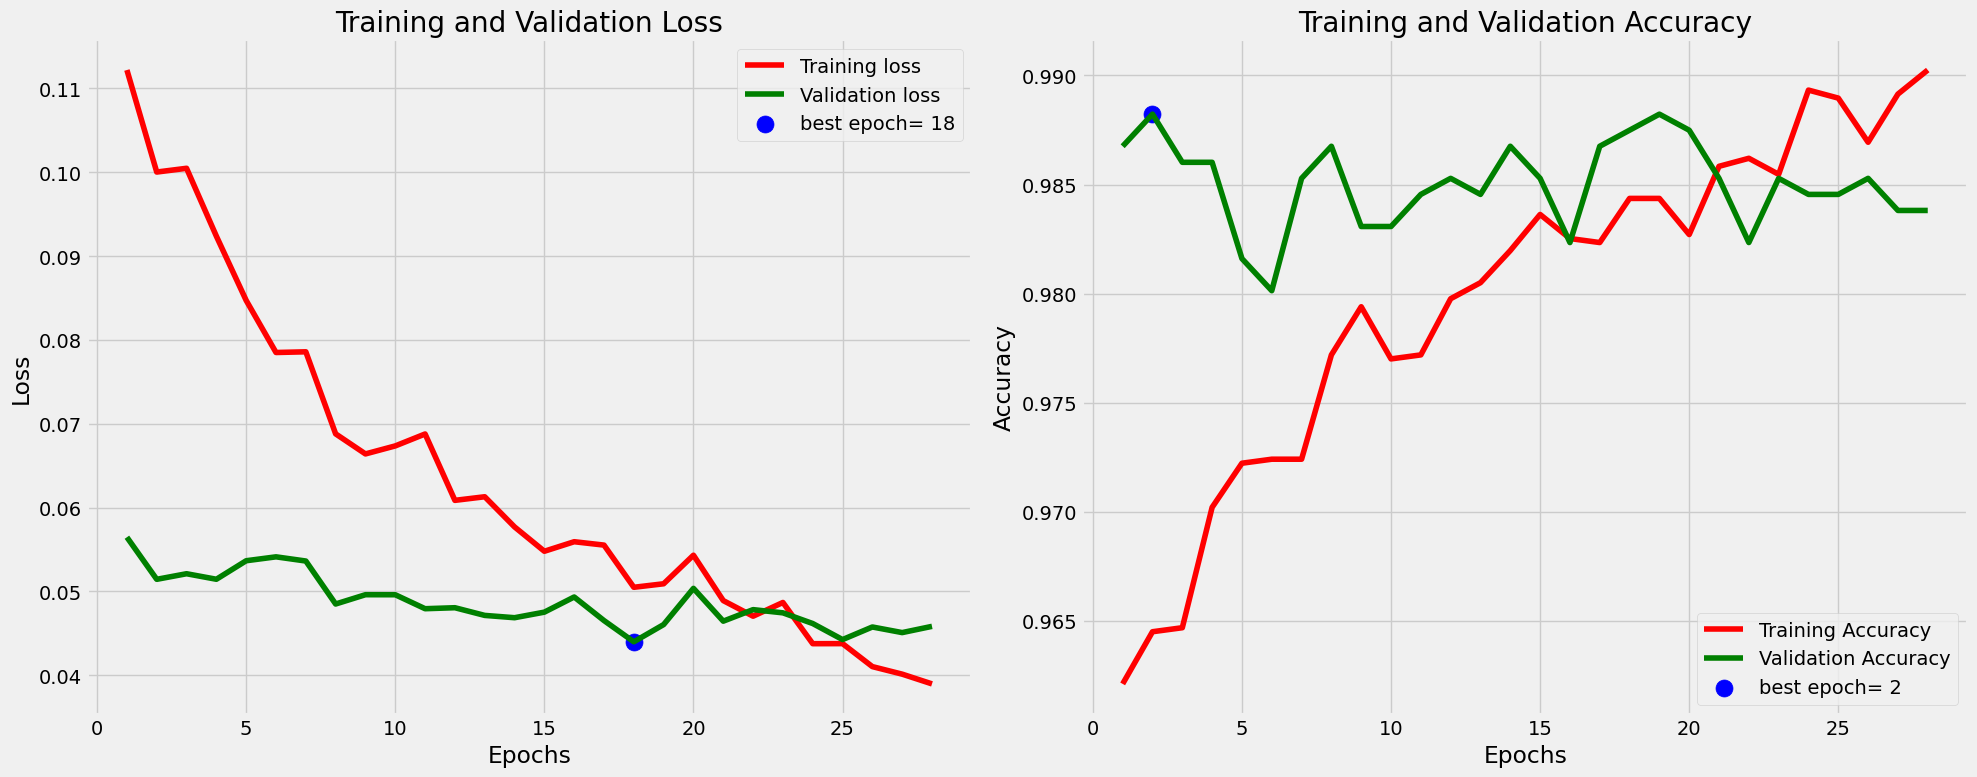

43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 997ms/step
Classification Report for Fold 2
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       330
           1       0.97      0.98      0.97       284
           2       1.00      1.00      1.00       391
           3       1.00      0.99      1.00       354

    accuracy                           0.99      1359
   macro avg       0.99      0.99      0.99      1359
weighted avg       0.99      0.99      0.99      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step


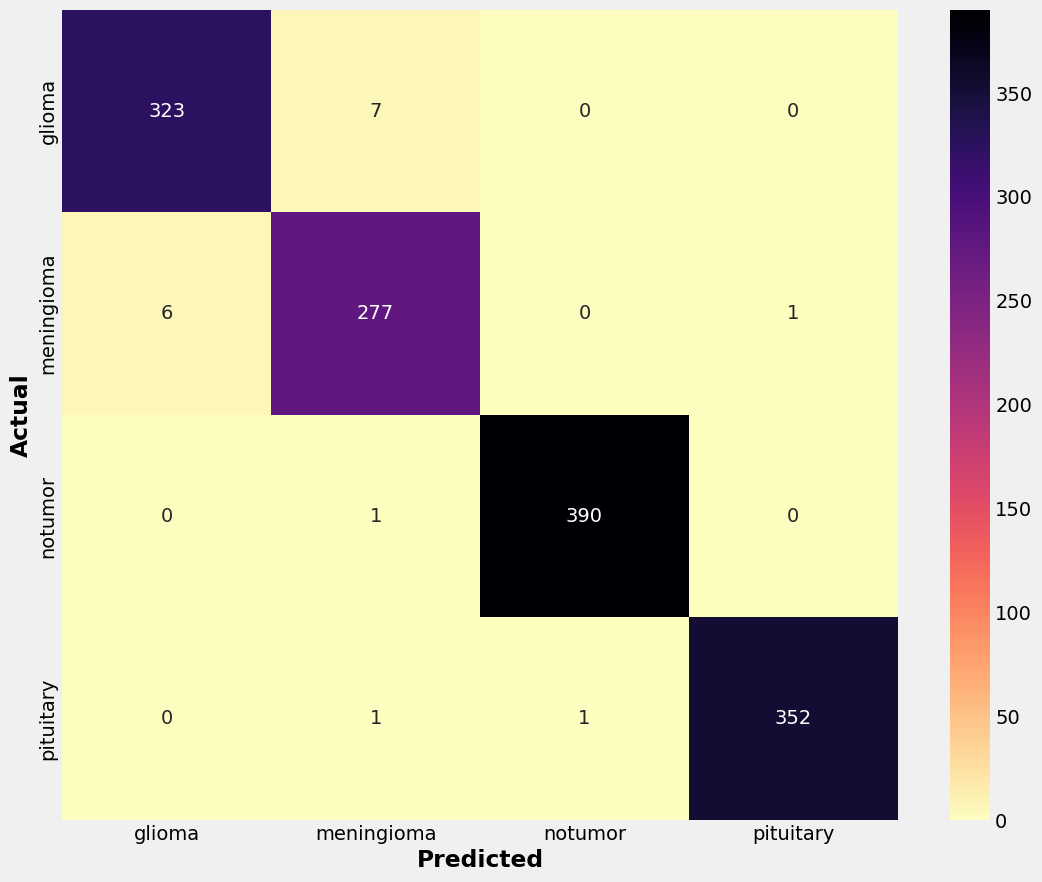

Fold 3/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.9798 - loss: 0.0632 - val_accuracy: 0.9956 - val_loss: 0.0233 - learning_rate: 3.1250e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9845 - loss: 0.0503 - val_accuracy: 0.9963 - val_loss: 0.0240 - learning_rate: 3.1250e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9864 - loss: 0.0489 - val_accuracy: 0.9956 - val_loss: 0.0243 - learning_rate: 3.1250e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.9835 - loss: 0.0530 - val_accuracy: 0.9963 - val_loss: 0.0245 - learning_rate: 3.1250e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.9876 - loss: 0.0489 - val_accuracy: 0.9963 - val_loss: 0.0237 - learning_rate: 3.1250e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9863 - loss: 0.0465 - val_accuracy: 0.9963 - val_loss: 0.0239 - learning_rate: 3.1250e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy

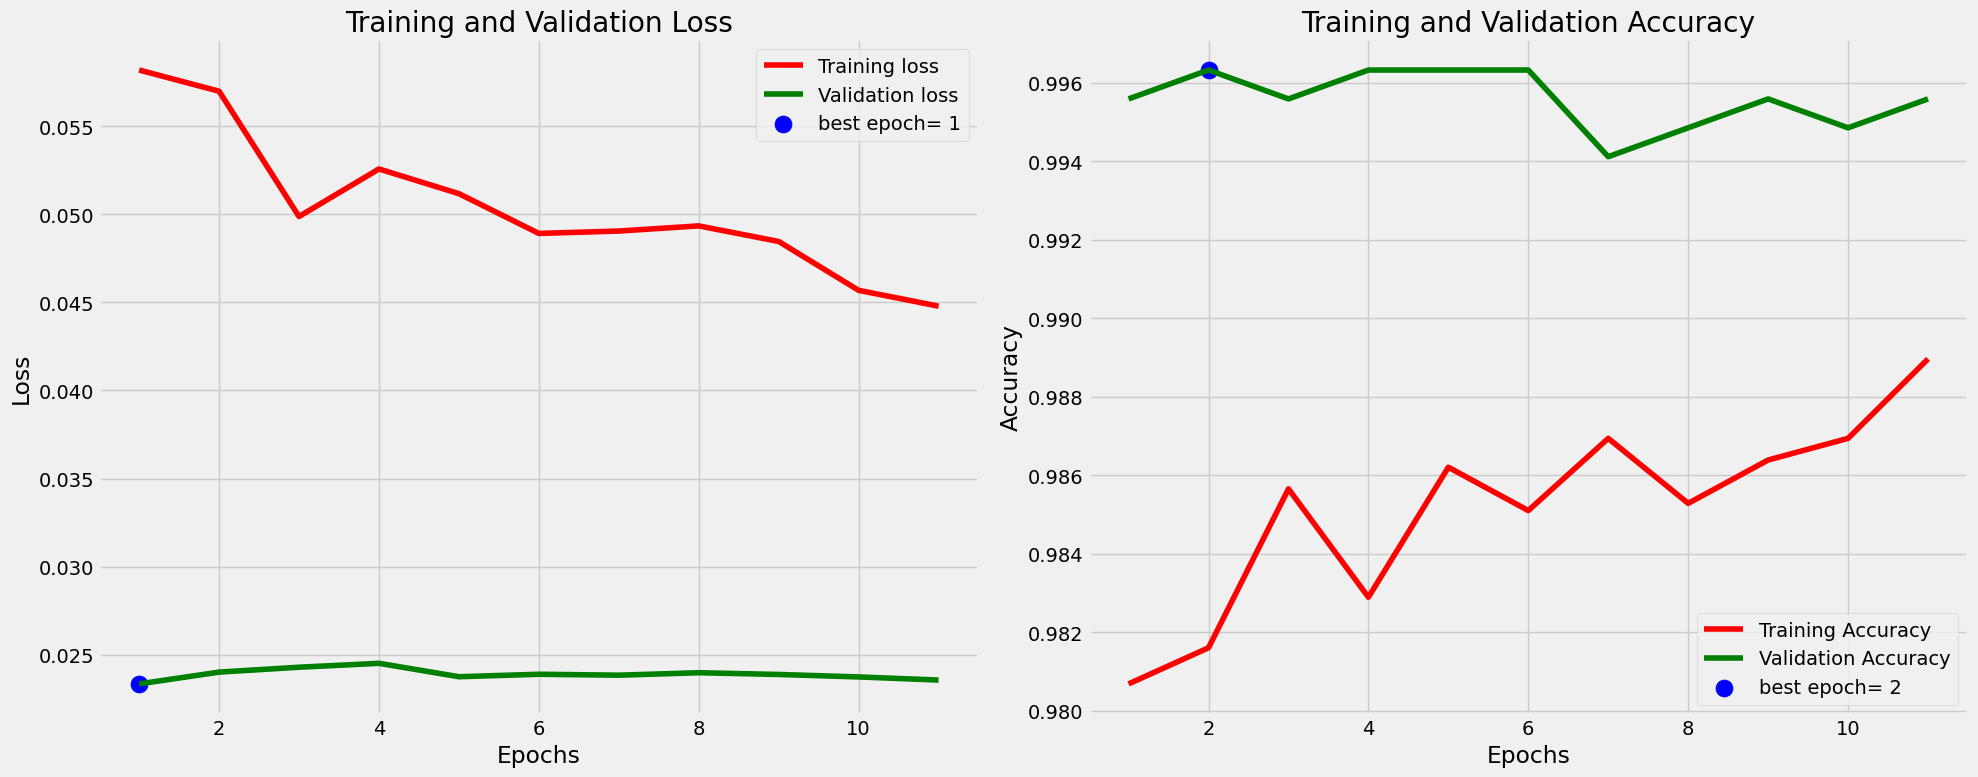

43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 847ms/step
Classification Report for Fold 3
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       326
           1       0.98      1.00      0.99       287
           2       1.00      1.00      1.00       415
           3       1.00      1.00      1.00       331

    accuracy                           1.00      1359
   macro avg       0.99      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 35s 823ms/step


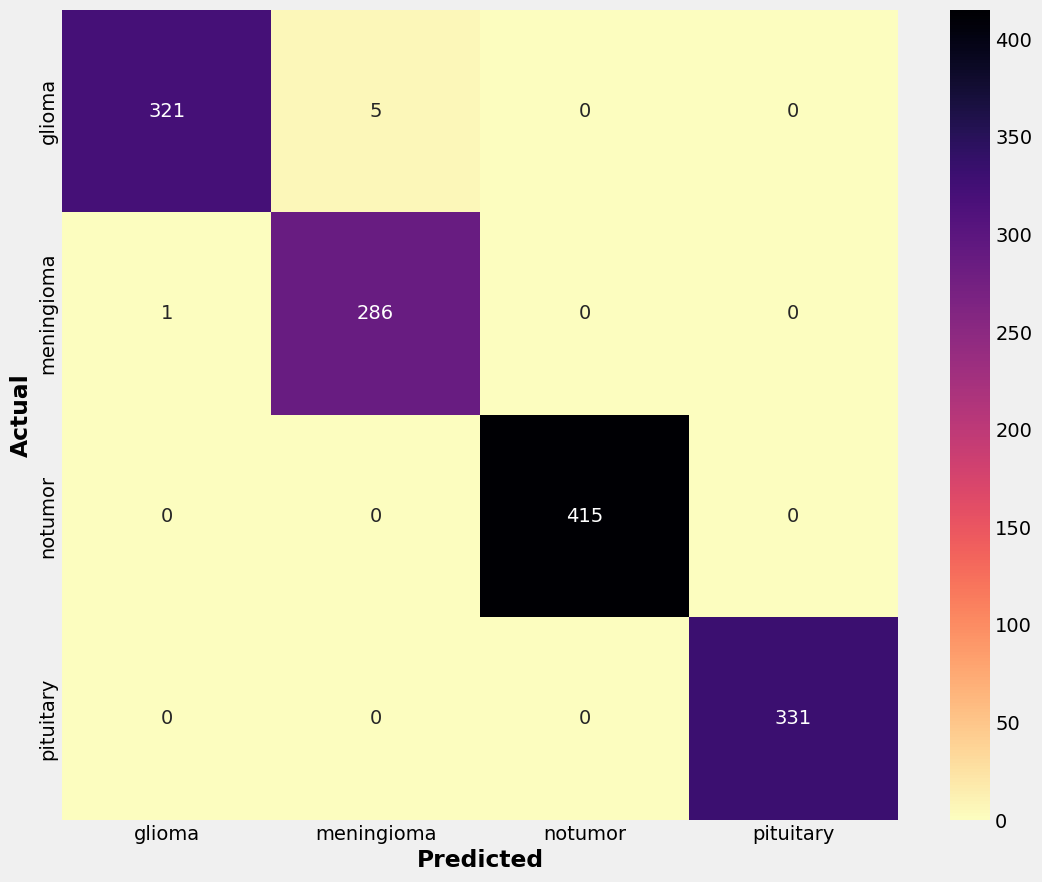

Fold 4/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.9824 - loss: 0.0589 - val_accuracy: 0.9978 - val_loss: 0.0217 - learning_rate: 1.0000e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9824 - loss: 0.0558 - val_accuracy: 0.9978 - val_loss: 0.0219 - learning_rate: 1.0000e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9843 - loss: 0.0500 - val_accuracy: 0.9985 - val_loss: 0.0222 - learning_rate: 1.0000e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.9826 - loss: 0.0526 - val_accuracy: 0.9978 - val_loss: 0.0218 - learning_rate: 1.0000e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9856 - loss: 0.0505 - val_accuracy: 0.9978 - val_loss: 0.0219 - learning_rate: 1.0000e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9849 - loss: 0.0505 - val_accuracy: 0.9978 - val_loss: 0.0217 - learning_rate: 1.0000e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy

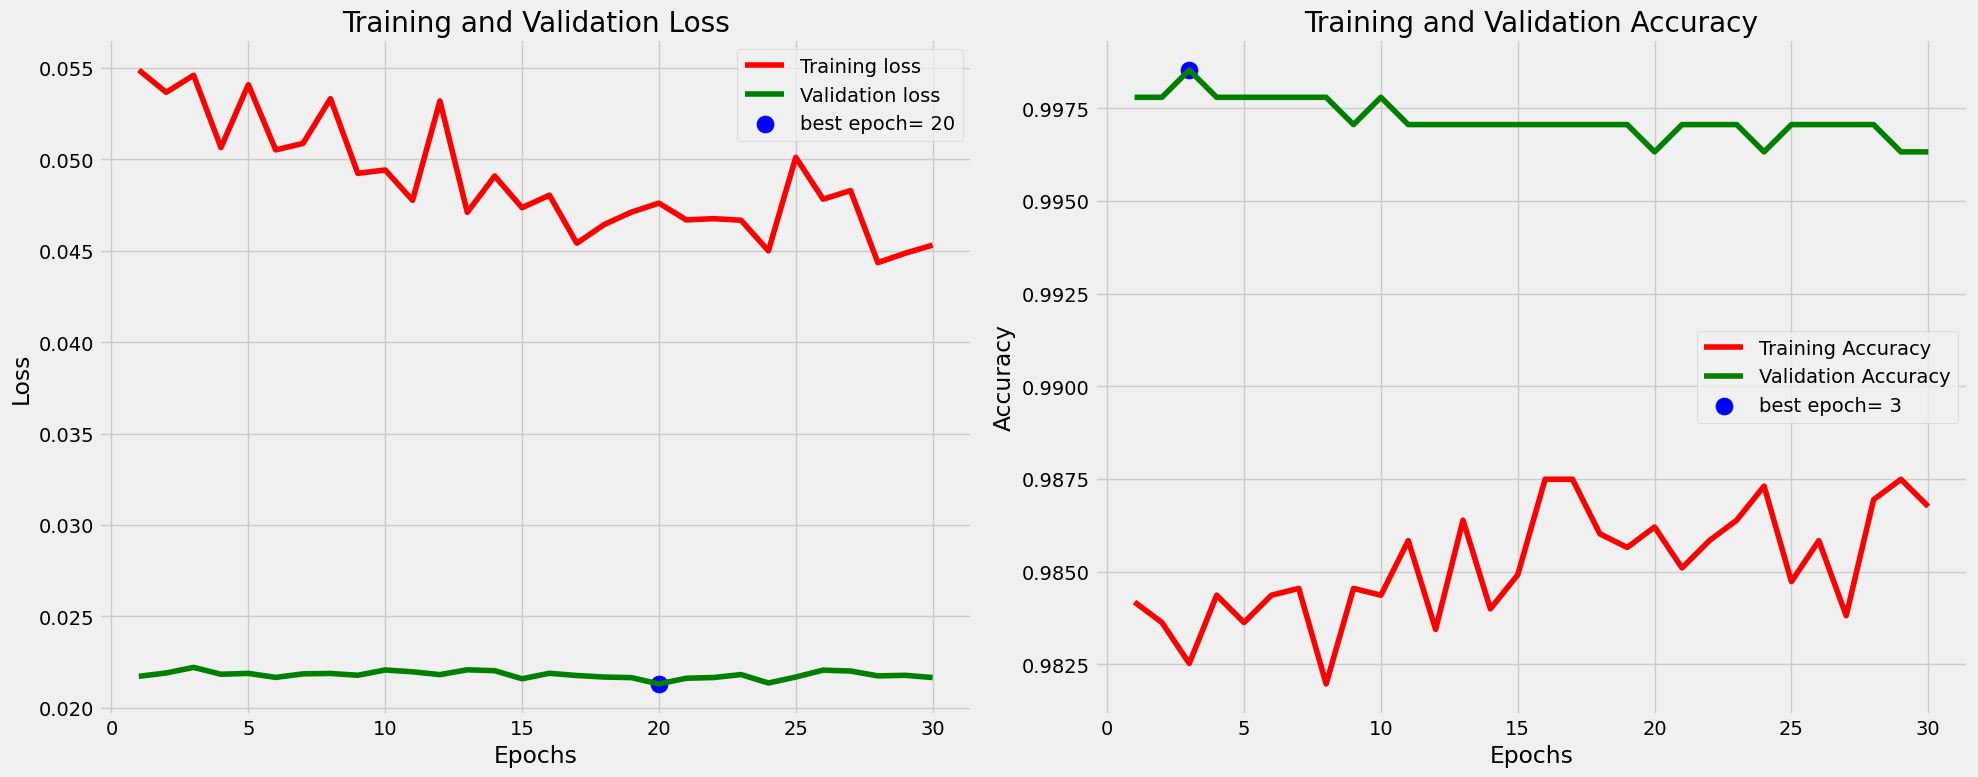

43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 779ms/step
Classification Report for Fold 4
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       326
           1       0.98      1.00      0.99       284
           2       1.00      1.00      1.00       374
           3       1.00      1.00      1.00       375

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 778ms/step


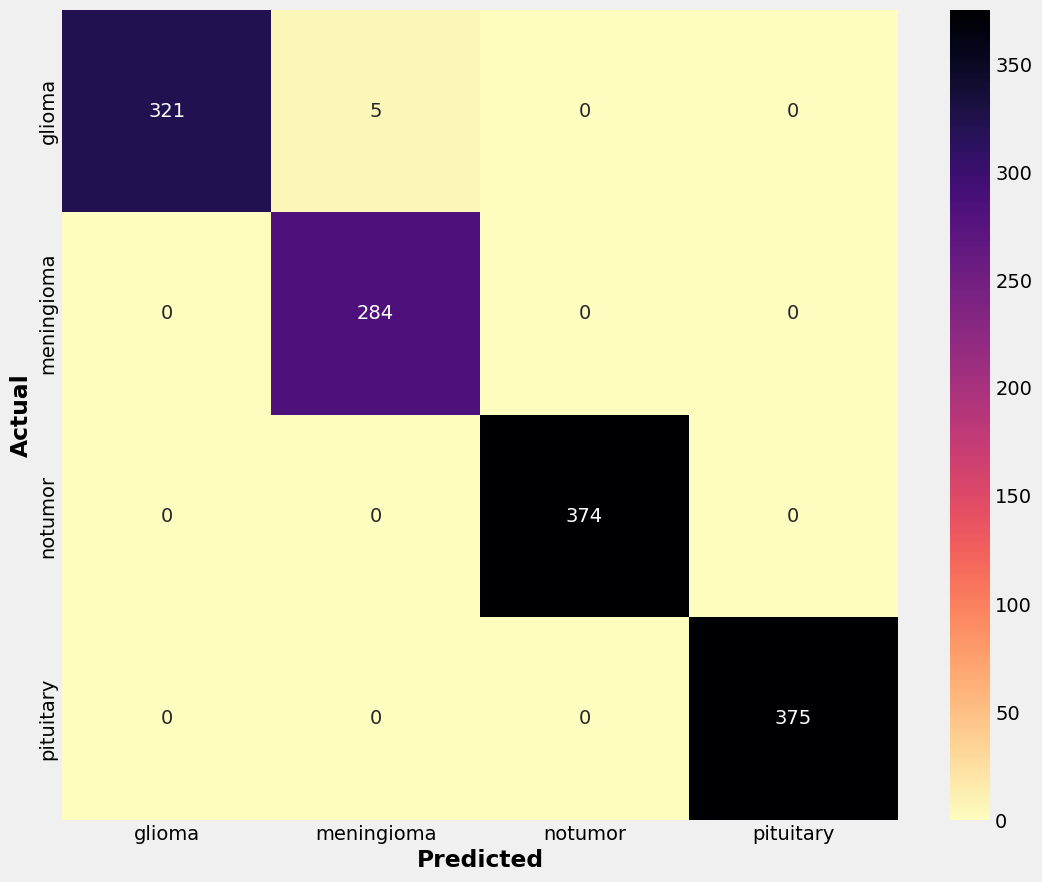

Fold 5/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.9839 - loss: 0.0475 - val_accuracy: 0.9978 - val_loss: 0.0195 - learning_rate: 1.0000e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9878 - loss: 0.0465 - val_accuracy: 0.9971 - val_loss: 0.0197 - learning_rate: 1.0000e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9873 - loss: 0.0453 - val_accuracy: 0.9971 - val_loss: 0.0196 - learning_rate: 1.0000e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9834 - loss: 0.0468 - val_accuracy: 0.9978 - val_loss: 0.0195 - learning_rate: 1.0000e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9848 - loss: 0.0463 - val_accuracy: 0.9978 - val_loss: 0.0197 - learning_rate: 1.0000e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.9866 - loss: 0.0470 - val_accuracy: 0.9978 - val_loss: 0.0197 - learning_rate: 1.0000e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy

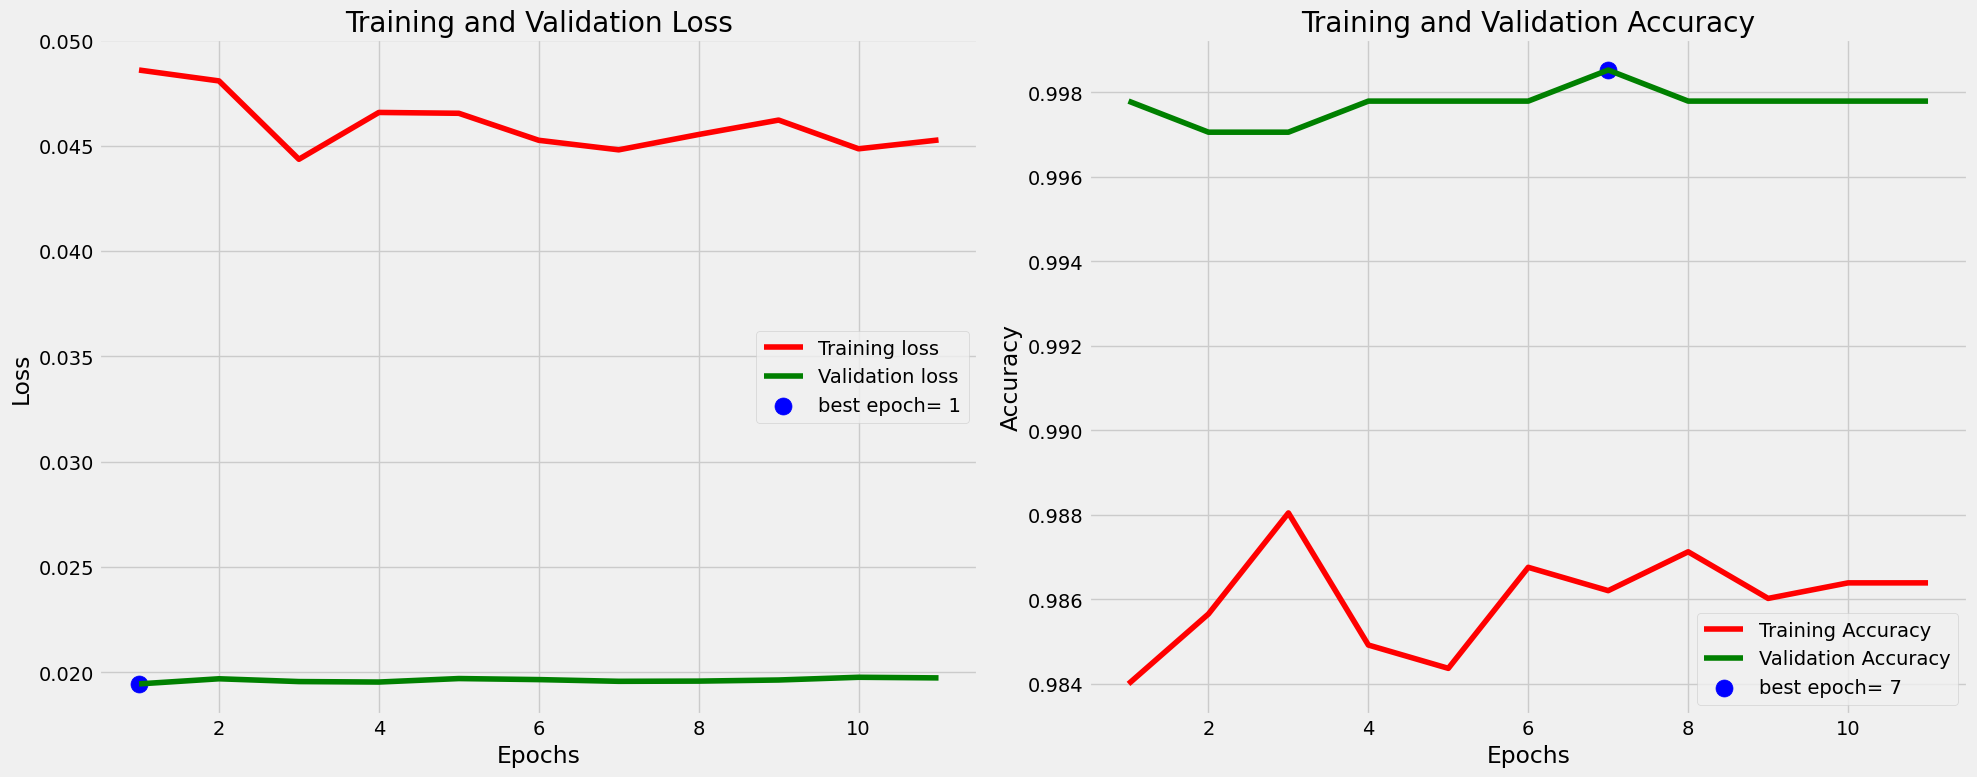

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 776ms/step
Classification Report for Fold 5
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       307
           1       0.99      1.00      0.99       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 775ms/step


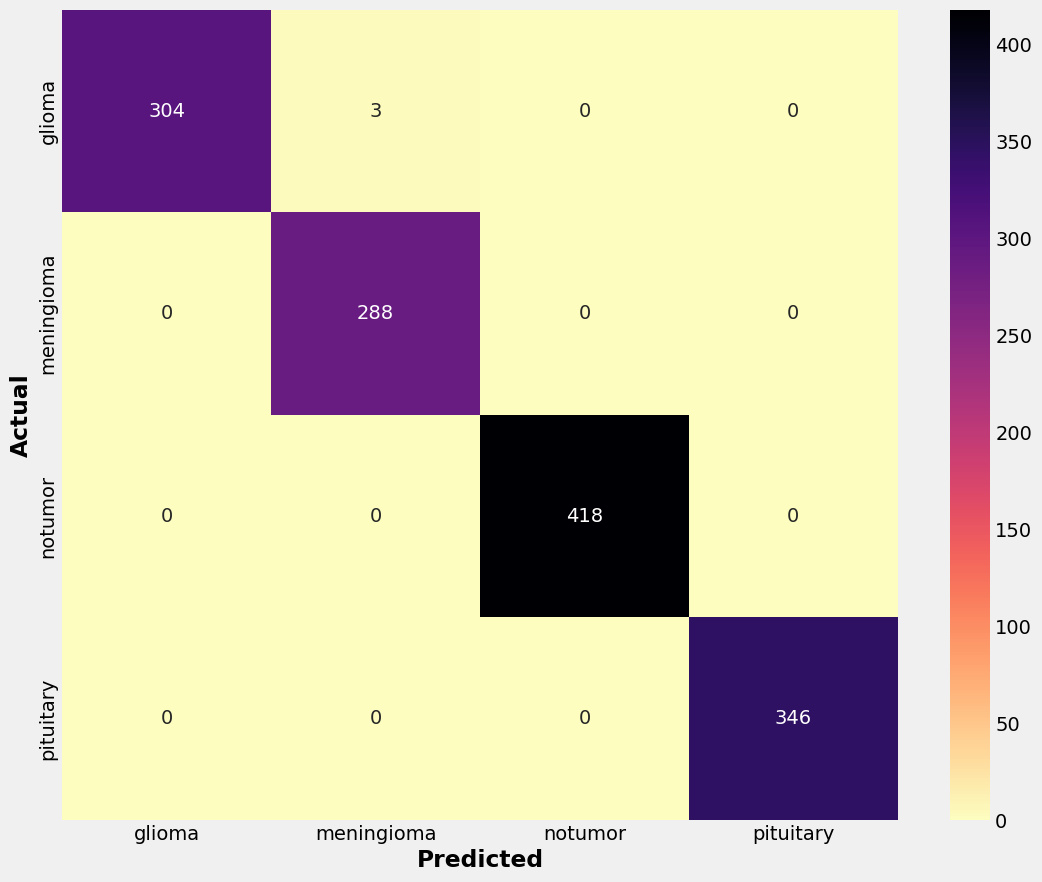

Total runtime of model: 339.0836740533511 Seconds


In [10]:
starting_time = time.time()   

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds) 

all_predictions = []
all_true_labels = []

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_one_encoded[train_index], y_train_one_encoded[val_index]

    # Train the model on this fold
    history_Xception = model_Xception.fit(X_train_fold, y_train_fold, epochs=30, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping, reduce_lr])

    # Evaluate the model on the validation fold
    scores = model_Xception.evaluate(X_val_fold, y_val_fold)
    print(f"Validation loss: {scores[0]}, Validation accuracy: {scores[1]}") 

    visualize_2(history_Xception)  
    
    # Generate predictions for the validation fold
    fold_predictions = np.argmax(model_Xception.predict(X_val_fold), axis=-1)
    fold_true_labels = np.argmax(y_val_fold, axis=-1)
    
    # Generate and print classification report for this fold
    fold_classification_report = classification_report(fold_true_labels, fold_predictions)
    print("Classification Report for Fold", fold + 1)
    print(fold_classification_report)  
    
    y_pred = model_Xception.predict(X_val_fold)  # X_test_normalized
    y_pred = np.argmax(y_pred,axis=1)   
    
    y_test_new = np.argmax(y_val_fold,axis=1) 

    conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.show()    
    
    
ending_time = time.time()    

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Seconds") 

In [11]:
# Evaluation
val_loss, val_acc = model_Xception.evaluate(X_val_fold, y_val_fold)  # X_test_normalized, y_test_one_encoded
print("Validation Accuracy: {:.2f}%".format(val_acc * 100))
print("Validation Loss: {:.2f}%".format(val_loss * 100))

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 777ms/step - accuracy: 0.9967 - loss: 0.0187
Validation Accuracy: 99.78%
Validation Loss: 1.98%


In [12]:
y_pred = model_Xception.predict(X_val_fold)  # X_test_normalized
y_pred = np.argmax(y_pred,axis=1) 

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 777ms/step


In [13]:
y_test_new = np.argmax(y_val_fold,axis=1)

In [14]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       307
           1       0.99      1.00      0.99       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359



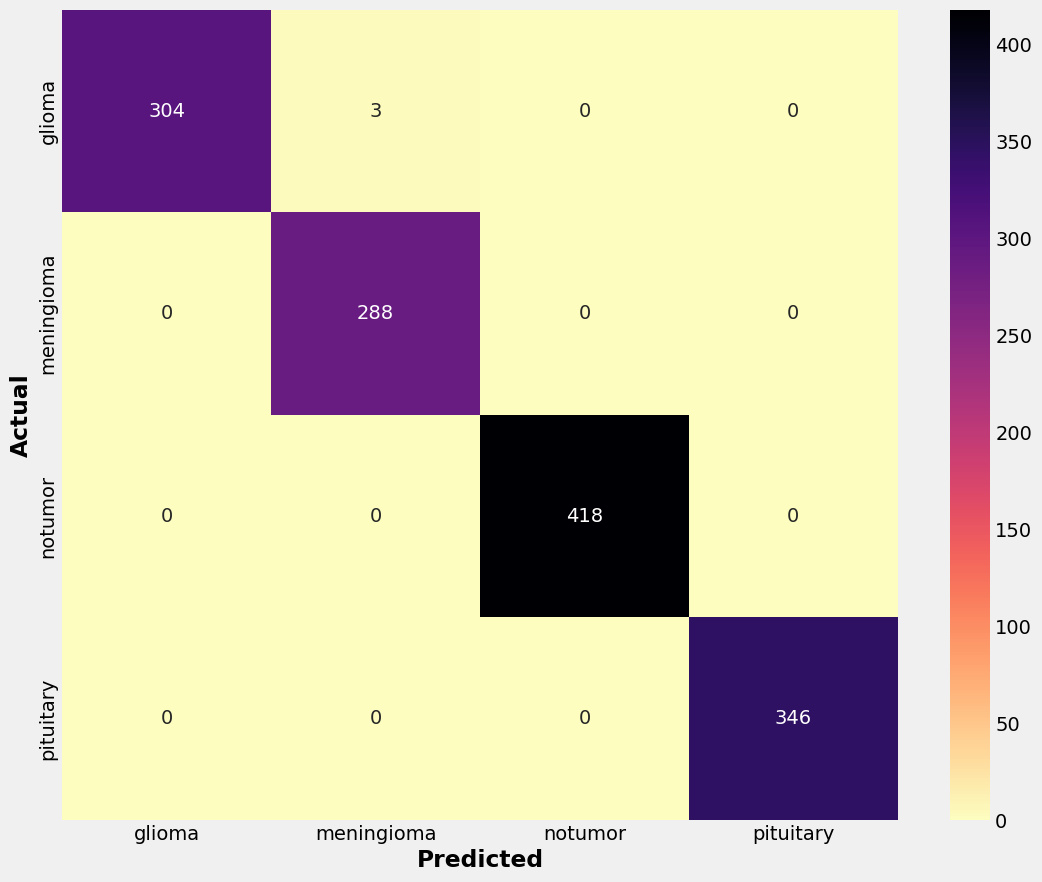

In [15]:
conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show() 

In [16]:
# saving the model 
save_model(model_Xception, 'saved_model_Xception_5K_lastone.keras') 

In [17]:
# Loading model 
model_modelXception = load_model('saved_model_Xception_5K_lastone.keras')

c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [18]:
second_last_layer_output = model_modelXception.layers[-2].output

feature_extractor_1 = Model(inputs=model_modelXception.input, outputs=second_last_layer_output)  

# feature_extractor_2.summary()

In [19]:
extracted_feature_Xception_Training = feature_extractor_1.predict(X_train_fold)

170/170 ━━━━━━━━━━━━━━━━━━━━ 133s 781ms/step


In [20]:
extracted_feature_Xception_Training.shape

(5436, 1024)

In [21]:
extracted_feature_Xception_Testing = feature_extractor_1.predict(X_val_fold)

43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step


In [22]:
extracted_feature_Xception_Testing.shape

(1359, 1024)

##  ///////////////////////////////////////////////////////  InceptionV3  //////////////////////////////////////////////////////////

In [23]:
# Main model 
base_model_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

NUM_CLASSES = 4    

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)  

# Freeze the layers in the base model
for layer in base_model_InceptionV3.layers:
    layer.trainable = False

# add global average pooling layer
x = base_model_InceptionV3.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x) 

# output layer
outputlayer_Inceptionv3 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)   

# Create the final model
model_InceptionV3 = Model(inputs=base_model_InceptionV3.input, outputs=outputlayer_Inceptionv3)

# Compile the model
model_InceptionV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

Fold 1/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 86s 978ms/step - accuracy: 0.4446 - loss: 25.3686 - val_accuracy: 0.6299 - val_loss: 1.8779 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.7388 - loss: 0.9814 - val_accuracy: 0.8160 - val_loss: 0.5456 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.7266 - loss: 1.0911 - val_accuracy: 0.7447 - val_loss: 0.8605 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 961ms/step - accuracy: 0.7848 - loss: 0.6404 - val_accuracy: 0.7689 - val_loss: 0.6778 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 963ms/step - accuracy: 0.8293 - loss: 0.5078 - val_accuracy: 0.7734 - val_loss: 0.8661 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.8298 - loss: 0.5082 - val_accuracy: 0.7896 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 964ms/step - accuracy: 0.8458 

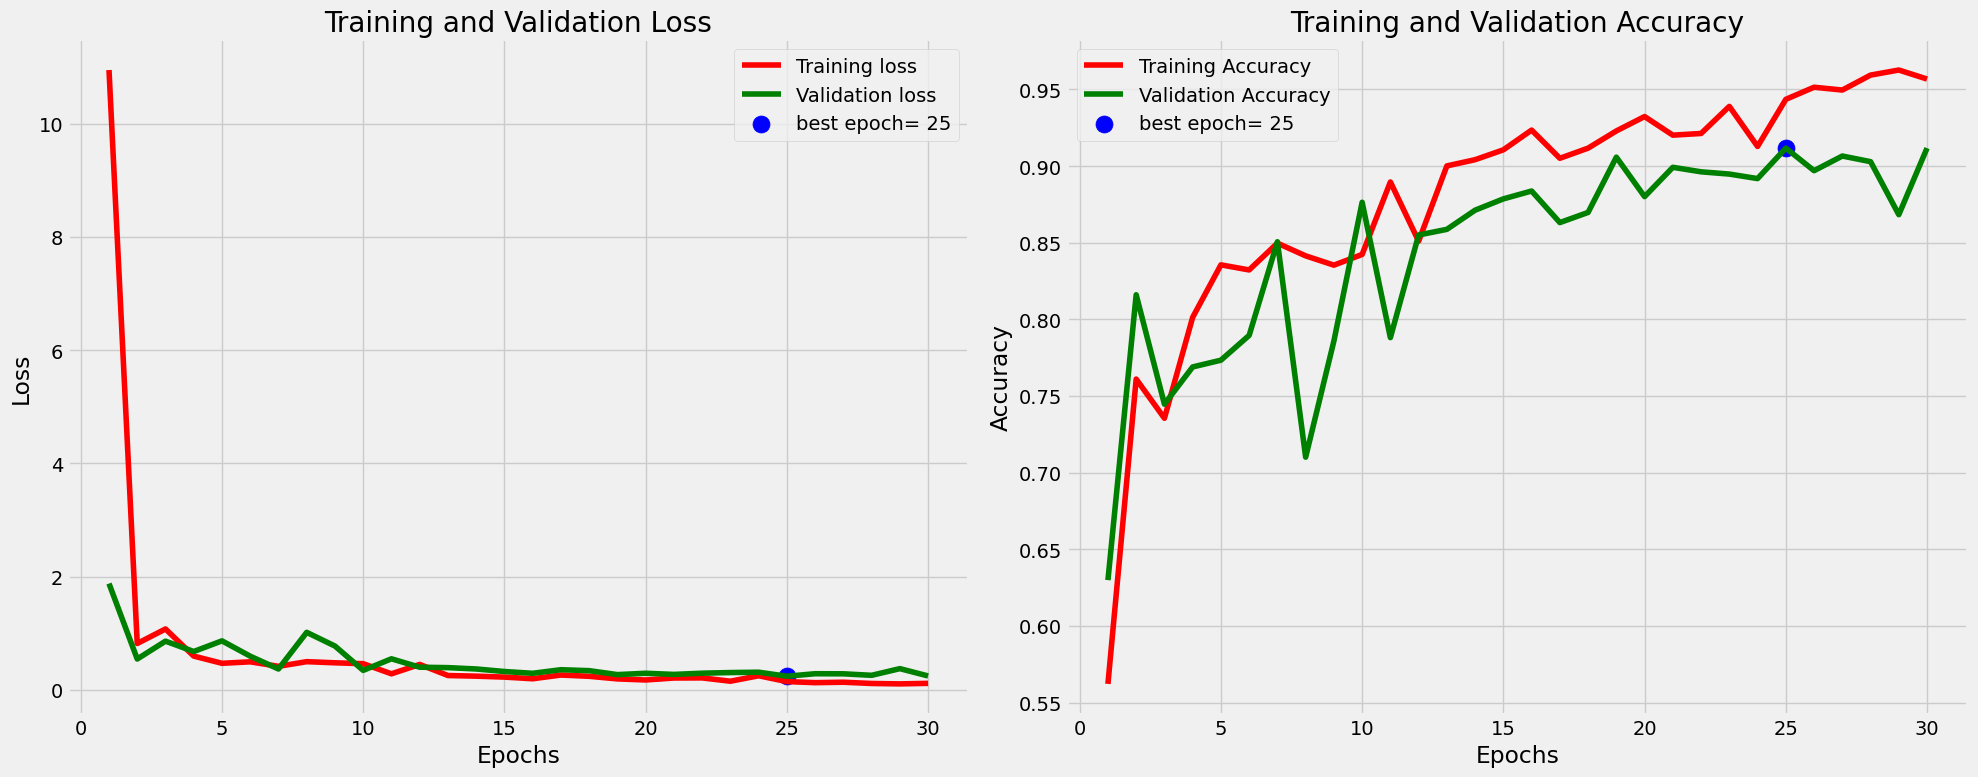

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step - accuracy: 0.9180 - loss: 0.2191
Validation loss: 0.24124282598495483, Validation accuracy: 0.9116997718811035
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 397ms/step
Classification Report for Fold 1
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       332
           1       0.79      0.85      0.82       277
           2       0.97      0.99      0.98       401
           3       0.96      0.95      0.96       349

    accuracy                           0.91      1359
   macro avg       0.90      0.90      0.90      1359
weighted avg       0.91      0.91      0.91      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 378ms/step


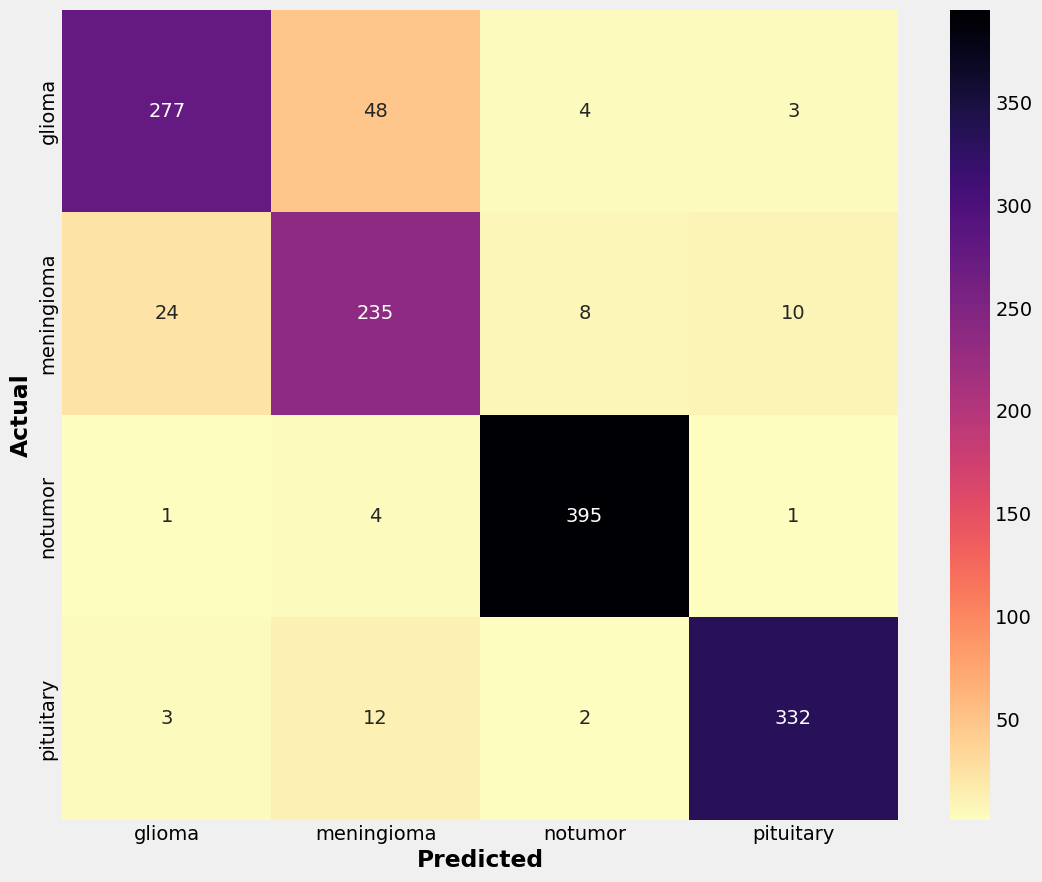

Fold 2/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.9529 - loss: 0.1391 - val_accuracy: 0.9603 - val_loss: 0.1133 - learning_rate: 2.5000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.9517 - loss: 0.1338 - val_accuracy: 0.9595 - val_loss: 0.1154 - learning_rate: 2.5000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 964ms/step - accuracy: 0.9540 - loss: 0.1260 - val_accuracy: 0.9507 - val_loss: 0.1264 - learning_rate: 2.5000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 964ms/step - accuracy: 0.9533 - loss: 0.1253 - val_accuracy: 0.9603 - val_loss: 0.1081 - learning_rate: 2.5000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.9646 - loss: 0.1096 - val_accuracy: 0.9551 - val_loss: 0.1140 - learning_rate: 2.5000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 968ms/step - accuracy: 0.9613 - loss: 0.1159 - val_accuracy: 0.9617 - val_loss: 0.1130 - learning_rate: 2.5000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 966ms/s

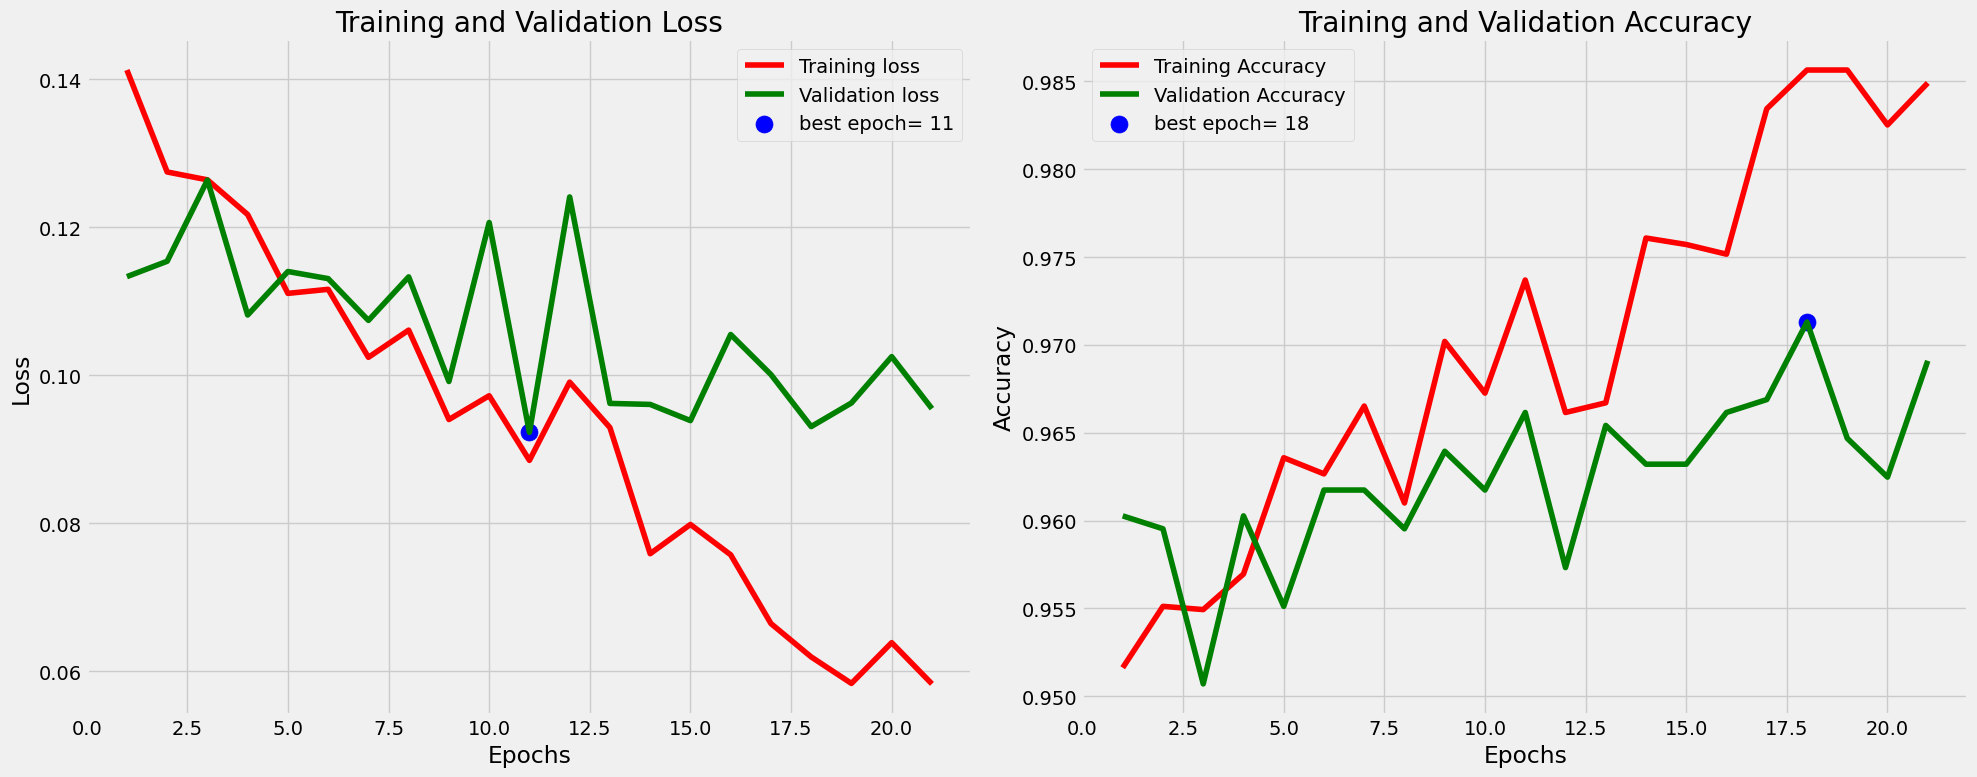

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - accuracy: 0.9665 - loss: 0.0965
Validation loss: 0.09380818158388138, Validation accuracy: 0.9661515951156616
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step
Classification Report for Fold 2
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       330
           1       0.92      0.93      0.93       284
           2       0.99      0.99      0.99       391
           3       0.98      0.98      0.98       354

    accuracy                           0.97      1359
   macro avg       0.96      0.96      0.96      1359
weighted avg       0.97      0.97      0.97      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step


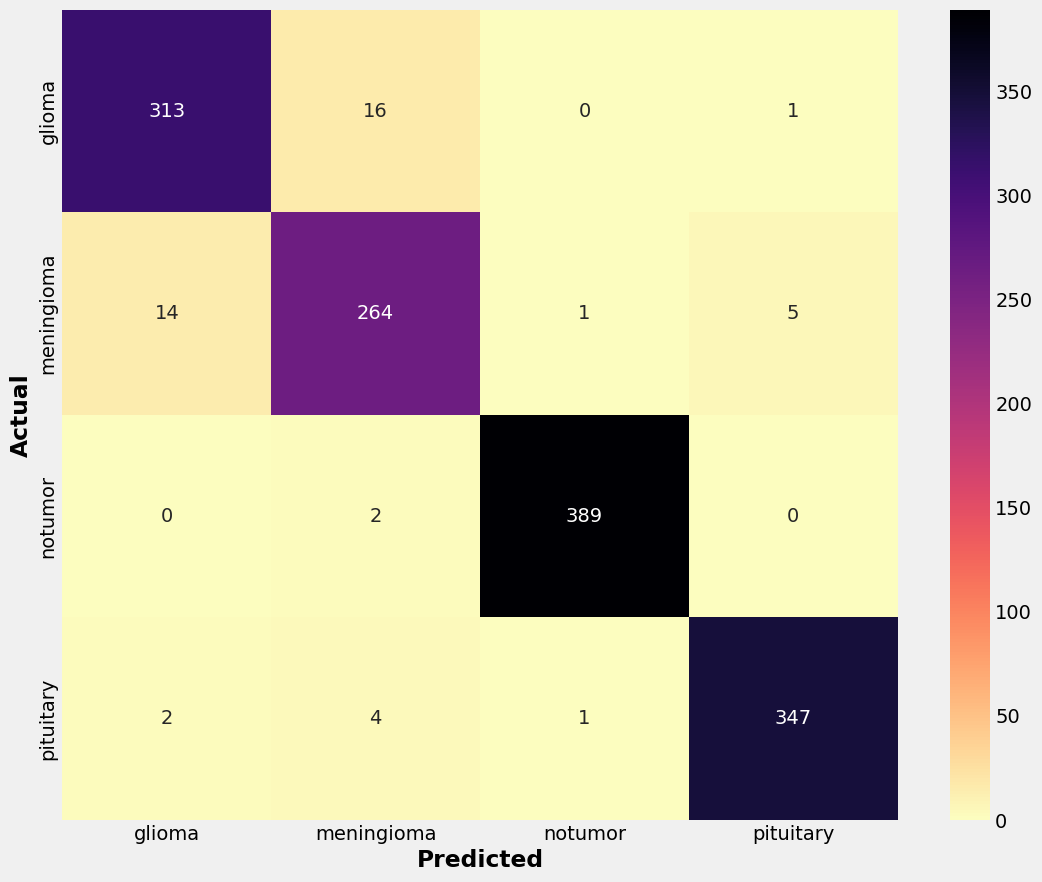

Fold 3/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.9787 - loss: 0.0854 - val_accuracy: 0.9860 - val_loss: 0.0573 - learning_rate: 6.2500e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 970ms/step - accuracy: 0.9772 - loss: 0.0785 - val_accuracy: 0.9838 - val_loss: 0.0592 - learning_rate: 6.2500e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 970ms/step - accuracy: 0.9756 - loss: 0.0863 - val_accuracy: 0.9853 - val_loss: 0.0592 - learning_rate: 6.2500e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.9782 - loss: 0.0760 - val_accuracy: 0.9816 - val_loss: 0.0653 - learning_rate: 6.2500e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 970ms/step - accuracy: 0.9811 - loss: 0.0731 - val_accuracy: 0.9794 - val_loss: 0.0711 - learning_rate: 6.2500e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.9786 - loss: 0.0709 - val_accuracy: 0.9801 - val_loss: 0.0634 - learning_rate: 6.2500e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/s

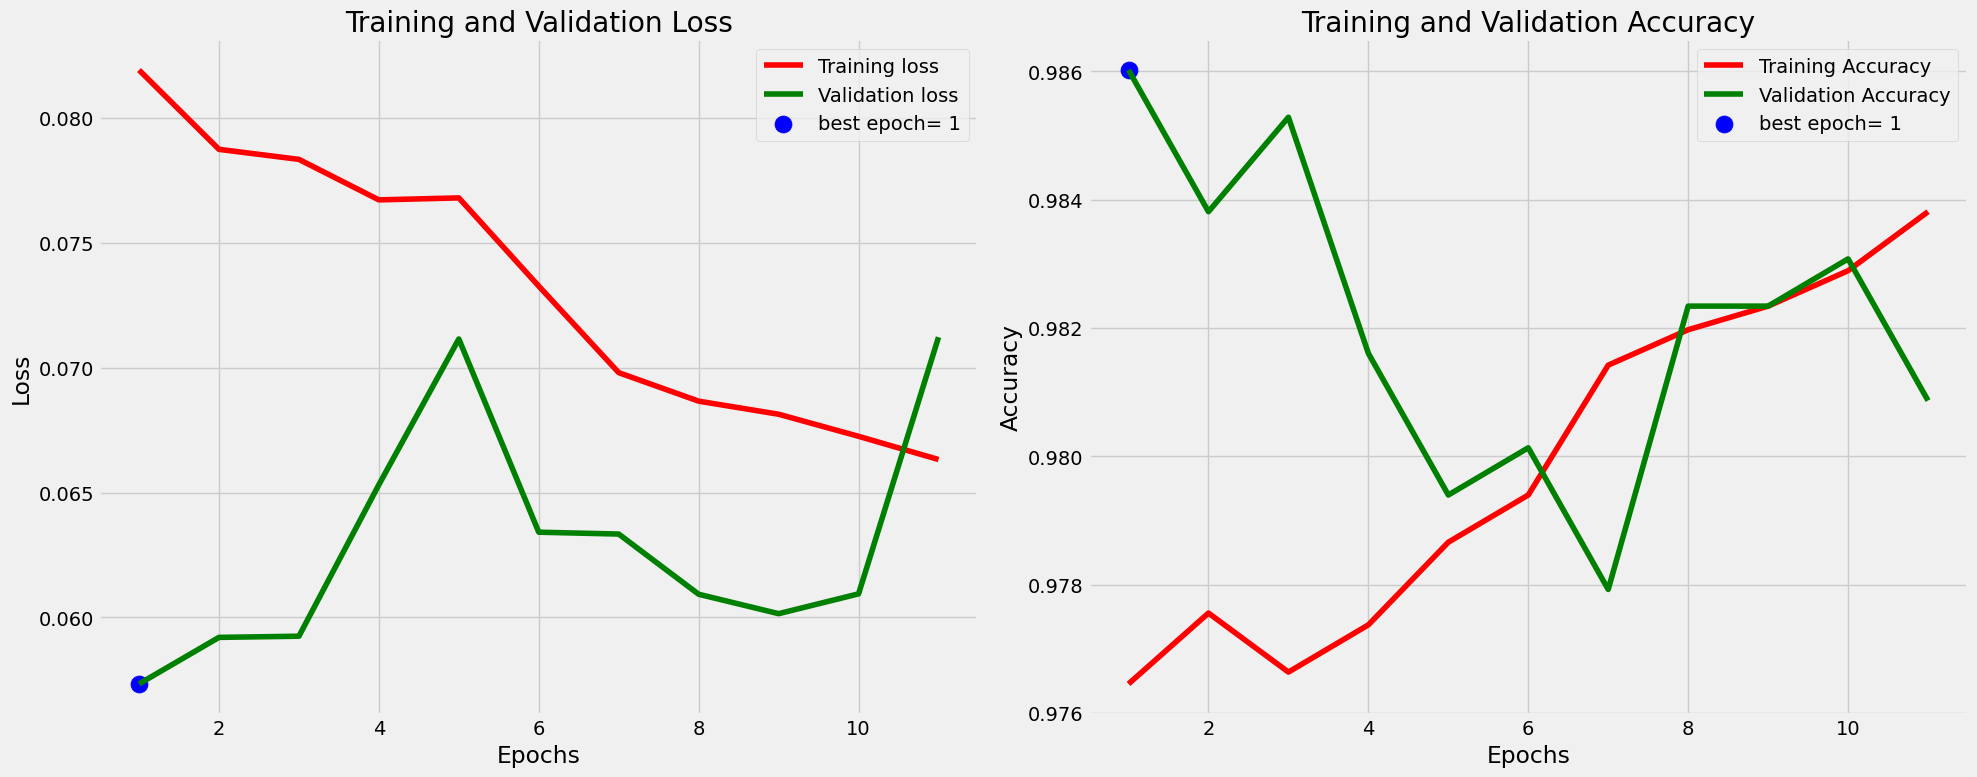

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - accuracy: 0.9874 - loss: 0.0565
Validation loss: 0.05815752223134041, Validation accuracy: 0.9860191345214844
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step
Classification Report for Fold 3
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       326
           1       0.96      0.98      0.97       287
           2       1.00      1.00      1.00       415
           3       0.99      1.00      1.00       331

    accuracy                           0.99      1359
   macro avg       0.98      0.98      0.98      1359
weighted avg       0.99      0.99      0.99      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step


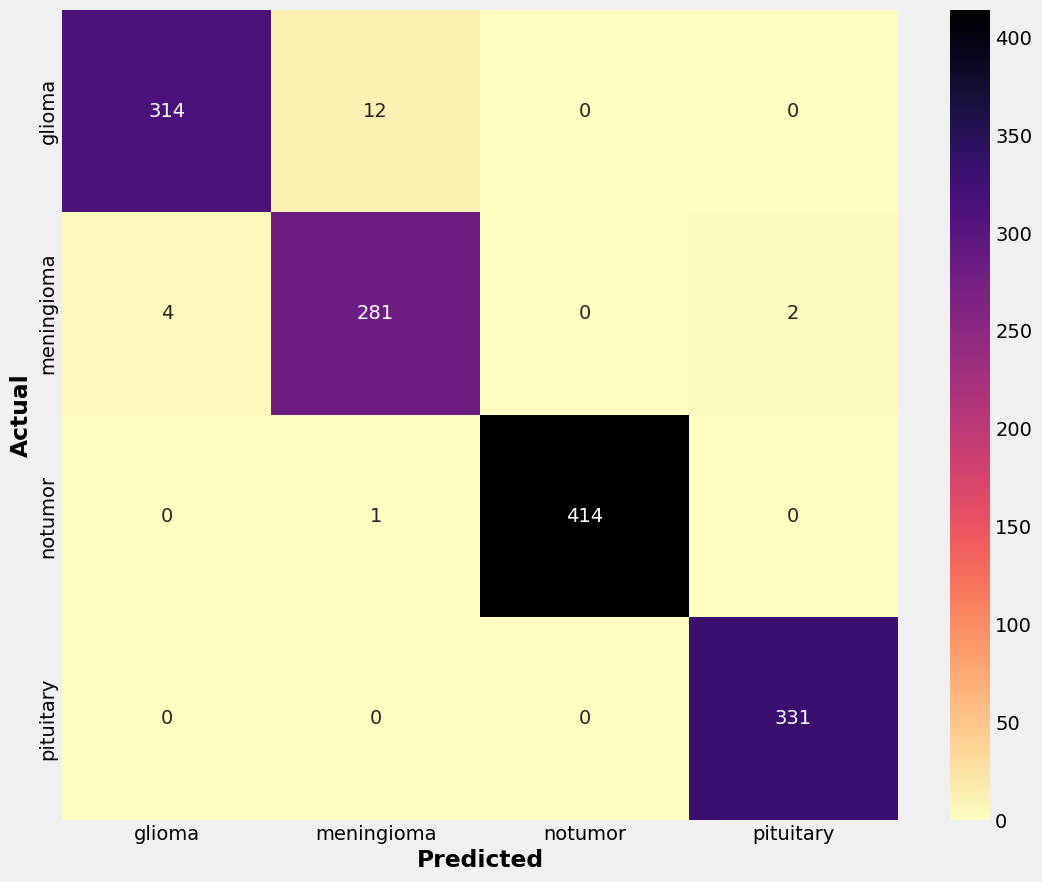

Fold 4/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/step - accuracy: 0.9749 - loss: 0.0773 - val_accuracy: 0.9904 - val_loss: 0.0582 - learning_rate: 1.5625e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 973ms/step - accuracy: 0.9779 - loss: 0.0812 - val_accuracy: 0.9897 - val_loss: 0.0607 - learning_rate: 1.5625e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 972ms/step - accuracy: 0.9774 - loss: 0.0776 - val_accuracy: 0.9868 - val_loss: 0.0630 - learning_rate: 1.5625e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 973ms/step - accuracy: 0.9828 - loss: 0.0708 - val_accuracy: 0.9845 - val_loss: 0.0600 - learning_rate: 1.5625e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 973ms/step - accuracy: 0.9812 - loss: 0.0722 - val_accuracy: 0.9838 - val_loss: 0.0619 - learning_rate: 1.5625e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 975ms/step - accuracy: 0.9792 - loss: 0.0746 - val_accuracy: 0.9897 - val_loss: 0.0593 - learning_rate: 1.5625e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 974ms/s

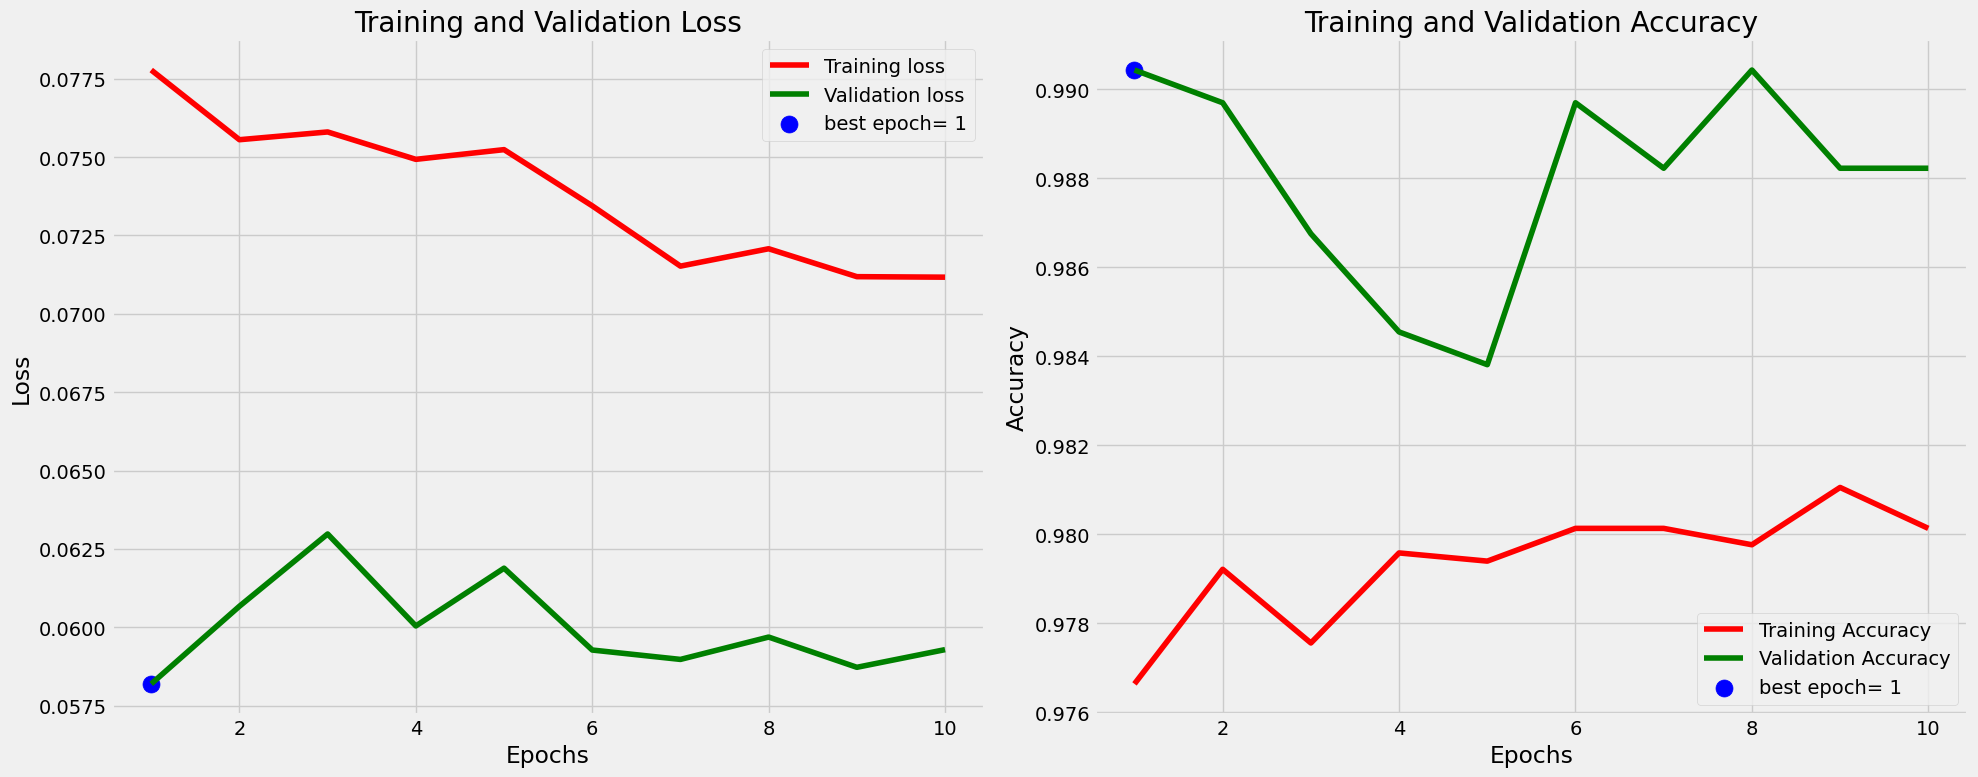

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - accuracy: 0.9905 - loss: 0.0573
Validation loss: 0.05827555060386658, Validation accuracy: 0.9904341697692871
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 384ms/step
Classification Report for Fold 4
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       326
           1       0.99      0.98      0.98       284
           2       1.00      1.00      1.00       374
           3       0.99      1.00      1.00       375

    accuracy                           0.99      1359
   macro avg       0.99      0.99      0.99      1359
weighted avg       0.99      0.99      0.99      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step


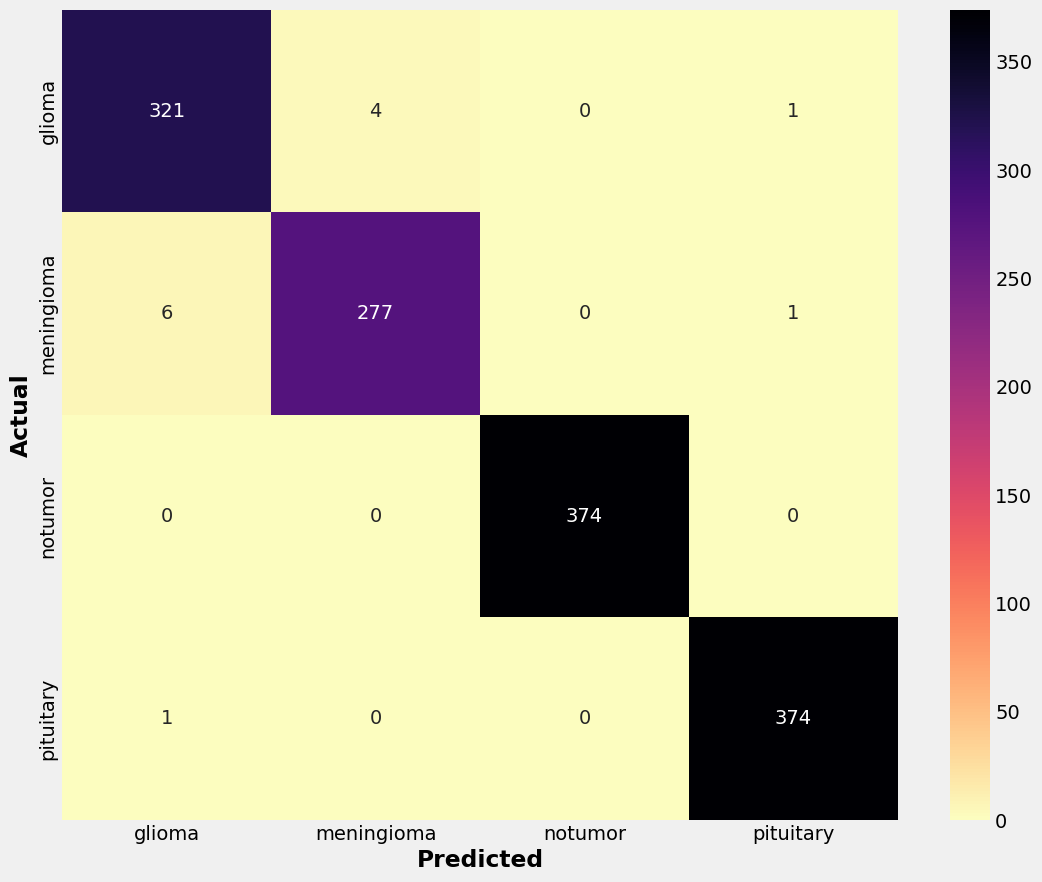

Fold 5/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 982ms/step - accuracy: 0.9765 - loss: 0.0793 - val_accuracy: 0.9897 - val_loss: 0.0537 - learning_rate: 1.0000e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 975ms/step - accuracy: 0.9803 - loss: 0.0725 - val_accuracy: 0.9868 - val_loss: 0.0597 - learning_rate: 1.0000e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 975ms/step - accuracy: 0.9777 - loss: 0.0770 - val_accuracy: 0.9919 - val_loss: 0.0535 - learning_rate: 1.0000e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 979ms/step - accuracy: 0.9813 - loss: 0.0717 - val_accuracy: 0.9919 - val_loss: 0.0539 - learning_rate: 1.0000e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 977ms/step - accuracy: 0.9801 - loss: 0.0693 - val_accuracy: 0.9919 - val_loss: 0.0560 - learning_rate: 1.0000e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 993ms/step - accuracy: 0.9817 - loss: 0.0678 - val_accuracy: 0.9919 - val_loss: 0.0526 - learning_rate: 1.0000e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 84s 990ms/s

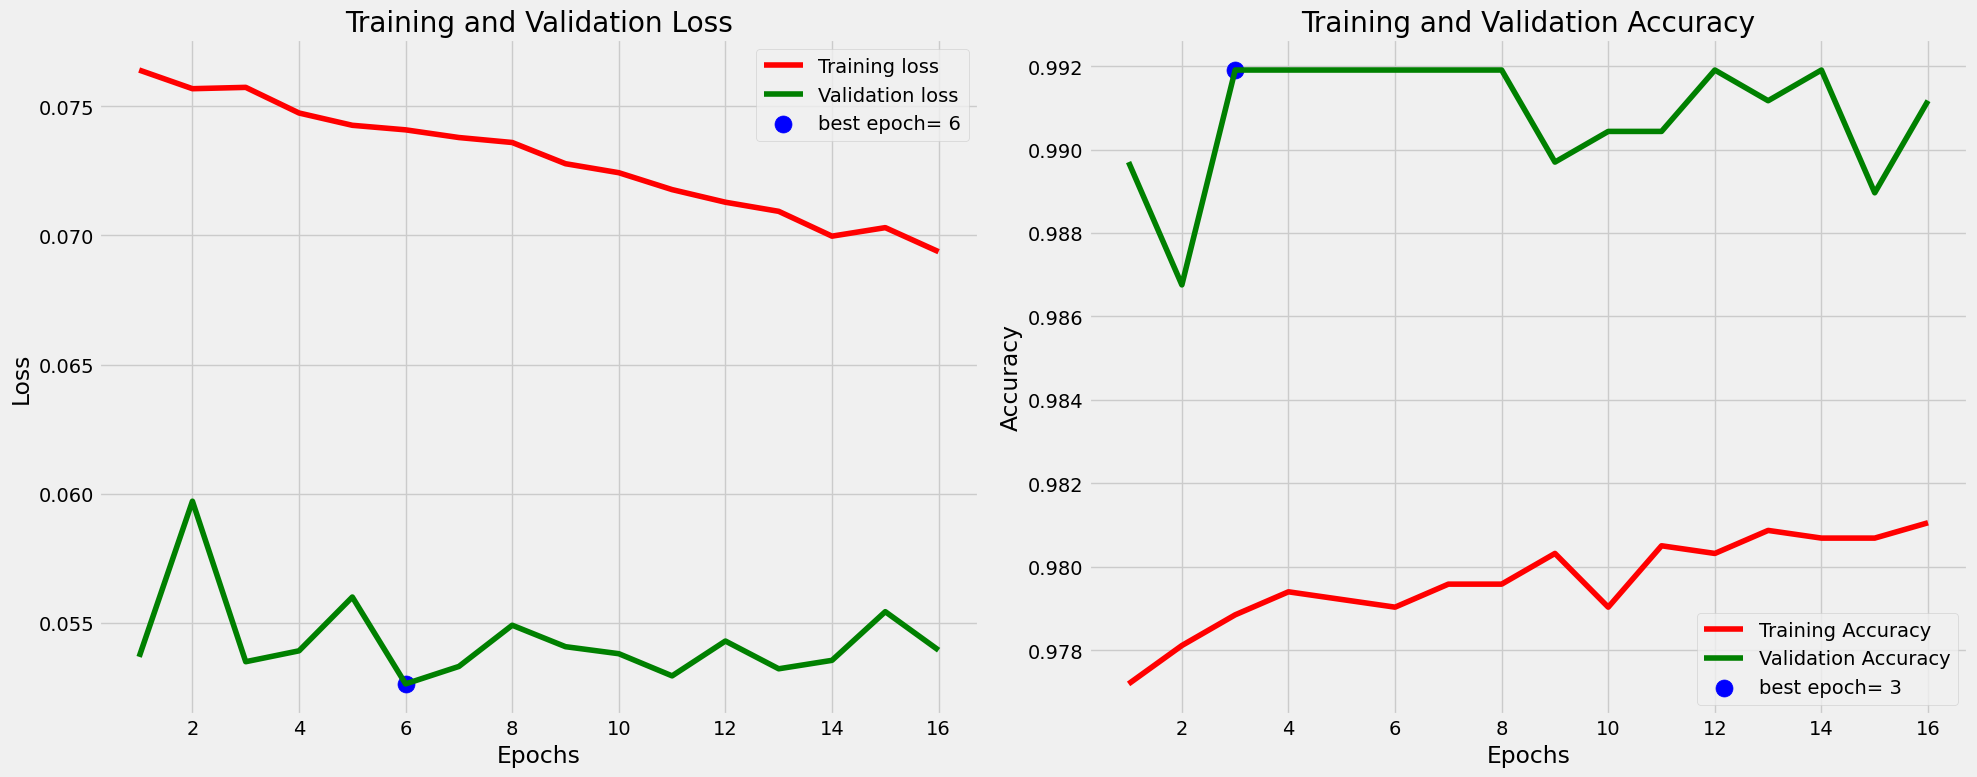

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 382ms/step - accuracy: 0.9900 - loss: 0.0579
Validation loss: 0.05338980257511139, Validation accuracy: 0.9919058084487915
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 387ms/step
Classification Report for Fold 5
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       307
           1       0.99      0.97      0.98       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           0.99      1359
   macro avg       0.99      0.99      0.99      1359
weighted avg       0.99      0.99      0.99      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 386ms/step


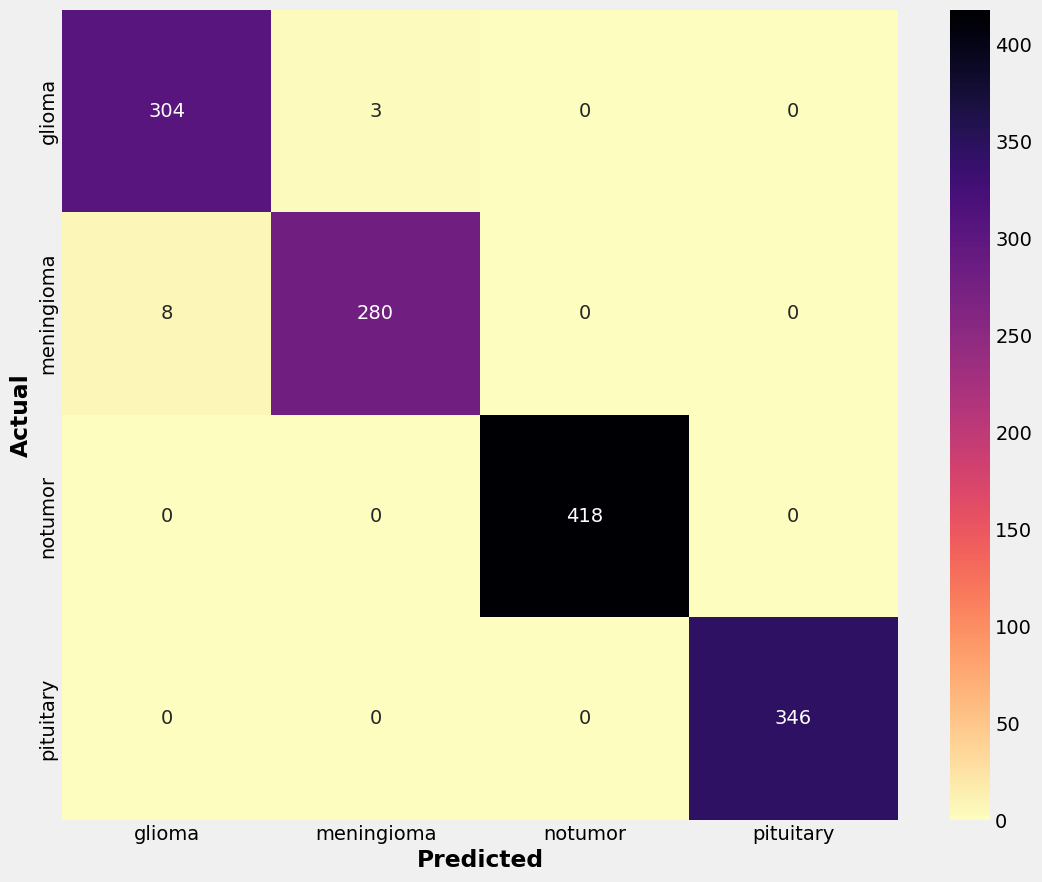

Total runtime of model: 125.20287248690923 Seconds


In [24]:
starting_time = time.time()   

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds) 

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_one_encoded[train_index], y_train_one_encoded[val_index]

    # Train the model on this fold
    history_InceptionV3 = model_InceptionV3.fit(X_train_fold, y_train_fold, epochs=30, batch_size=64, validation_data=(X_val_fold, y_val_fold),callbacks=[early_stopping, reduce_lr] )

    visualize_2(history_InceptionV3) 
    # Evaluate the model on the validation fold
    scores = model_InceptionV3.evaluate(X_val_fold, y_val_fold)
    print(f"Validation loss: {scores[0]}, Validation accuracy: {scores[1]}") 
    
    
    # Generate predictions for the validation fold
    fold_predictions_1 = np.argmax(model_InceptionV3.predict(X_val_fold), axis=-1)
    fold_true_labels_1 = np.argmax(y_val_fold, axis=-1)
    
    # Generate and print classification report for this fold
    fold_classification_report = classification_report(fold_true_labels_1, fold_predictions_1)
    print("Classification Report for Fold", fold + 1)
    print(fold_classification_report) 
    
    y_pred = model_InceptionV3.predict(X_val_fold)  # X_test_normalized
    y_pred = np.argmax(y_pred,axis=1)  
    y_test_new = np.argmax(y_val_fold,axis=1) 

    conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.show() 
    

ending_time = time.time()    

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Seconds") 

In [25]:
# Evaluation
val_loss, val_acc = model_InceptionV3.evaluate(X_val_fold, y_val_fold)  # X_test_normalized, y_test_one_encoded
print("Validation Accuracy: {:.2f}%".format(val_acc * 100))
print("Validation Loss: {:.2f}%".format(val_loss * 100))

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step - accuracy: 0.9900 - loss: 0.0579
Validation Accuracy: 99.19%
Validation Loss: 5.34%


In [26]:
y_pred = model_InceptionV3.predict(X_val_fold)  # X_test_normalized
y_pred = np.argmax(y_pred,axis=1) 

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 388ms/step


In [27]:
y_test_new = np.argmax(y_val_fold,axis=1)

In [28]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       307
           1       0.99      0.97      0.98       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           0.99      1359
   macro avg       0.99      0.99      0.99      1359
weighted avg       0.99      0.99      0.99      1359



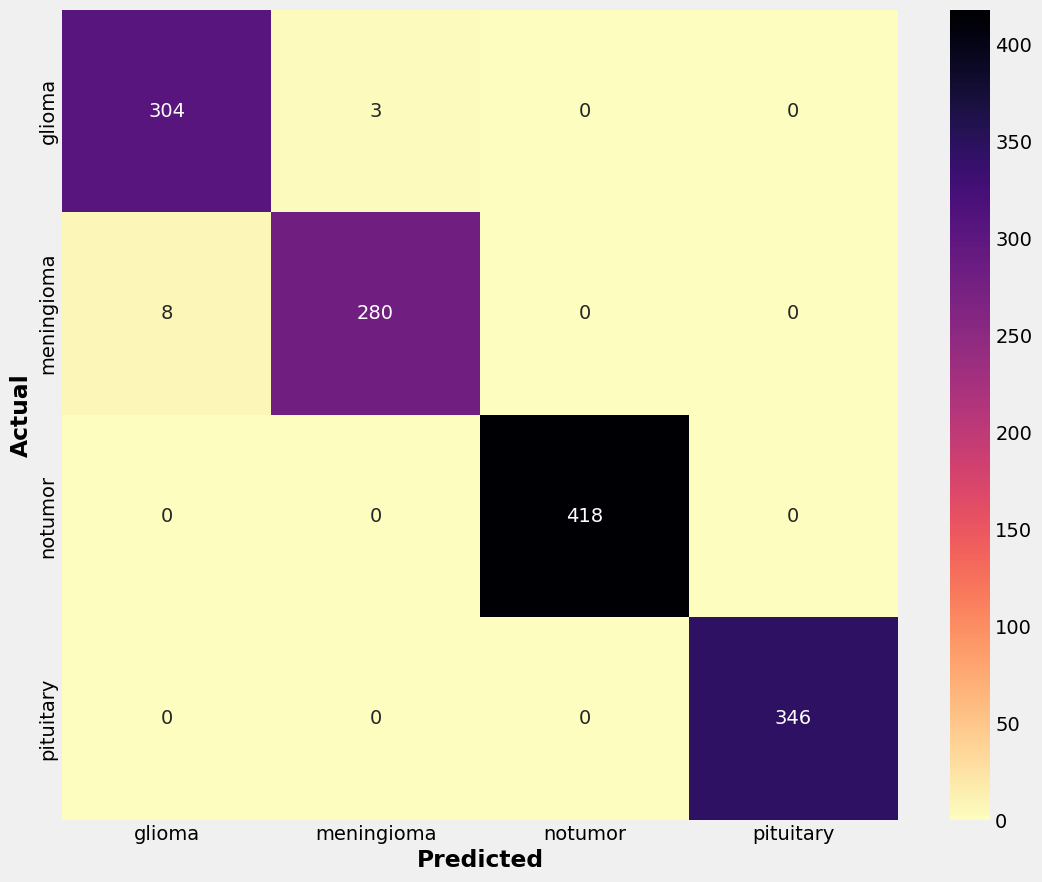

In [29]:
conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show() 

In [30]:
# saving the model 
save_model(model_InceptionV3, 'saved_model_InceptionV3_5K_lastone.keras') 

In [31]:
# Loading model 
model_modelInceptionV3 = load_model('saved_model_InceptionV3_5K_lastone.keras')

c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 386 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [32]:
second_last_layer_output = model_modelInceptionV3.layers[-2].output

feature_extractor_2 = Model(inputs=model_modelInceptionV3.input, outputs=second_last_layer_output)  

# feature_extractor_2.summary()

In [33]:
extracted_feature_InceptionV3_Training = feature_extractor_2.predict(X_train_fold)

170/170 ━━━━━━━━━━━━━━━━━━━━ 67s 388ms/step


In [34]:
extracted_feature_InceptionV3_Training.shape

(5436, 1024)

In [35]:
extracted_feature_InceptionV3_Testing = feature_extractor_2.predict(X_val_fold)

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step


In [36]:
extracted_feature_InceptionV3_Testing.shape

(1359, 1024)

##  /////////////////////////////////////////////////  DenseNet121  ////////////////////////////////////////////////////

## Resizing the images

In [37]:
labels = ['glioma','meningioma','notumor','pituitary']    

X_train = []
y_train = []
image_size = 224

for i in labels:
    folderPath = os.path.join('./DataSet','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('./DataSet','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train_1 = np.array(X_train)
y_train_1 = np.array(y_train)

100%|██████████| 300/300 [00:00<00:00, 918.70it/s]


In [38]:
X_train_1, y_train_1 = shuffle(X_train_1,y_train_1, random_state=101) 

In [39]:
labels = ['glioma','meningioma','notumor','pituitary']    
label_to_index = {labels: index for index, labels in enumerate(labels)}
y_train_indices = np.array([label_to_index[labels] for labels in y_train_1])

# Convert indices to one-hot encoded vectors
y_train_one_encoded_1 = tf.keras.utils.to_categorical(y_train_indices, num_classes=len(labels))

In [40]:
# Define base model
base_model_DenseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

NUM_CLASSES = 4 

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)  
 
# Freeze the layers of the base model
for layer in base_model_DenseNet121.layers:
    layer.trainable = False  

# Add global average pooling layer
x = base_model_DenseNet121.output
x = GlobalAveragePooling2D()(x)

# Fully connected layer
x = Dense(1024, activation='relu')(x)   

# Add dropout layer
x = tf.keras.layers.Dropout(0.5)(x)  # 0.5 is the dropout rate
# Output layer
output_layer_DenseNet121 = Dense(NUM_CLASSES, activation='softmax')(x)  

# Combine model
model_DenseNet121 = Model(inputs=base_model_DenseNet121.input, outputs=output_layer_DenseNet121)

# Compile the model
model_DenseNet121.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

Fold 1/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.5199 - loss: 2.8688 - val_accuracy: 0.8293 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 972ms/step - accuracy: 0.7754 - loss: 0.5700 - val_accuracy: 0.8330 - val_loss: 0.4517 - learning_rate: 0.0010
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 976ms/step - accuracy: 0.8199 - loss: 0.4719 - val_accuracy: 0.8469 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 966ms/step - accuracy: 0.8457 - loss: 0.4142 - val_accuracy: 0.8661 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 964ms/step - accuracy: 0.8424 - loss: 0.4041 - val_accuracy: 0.8756 - val_loss: 0.3396 - learning_rate: 0.0010
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 965ms/step - accuracy: 0.8663 - loss: 0.3443 - val_accuracy: 0.8749 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.8692 - lo

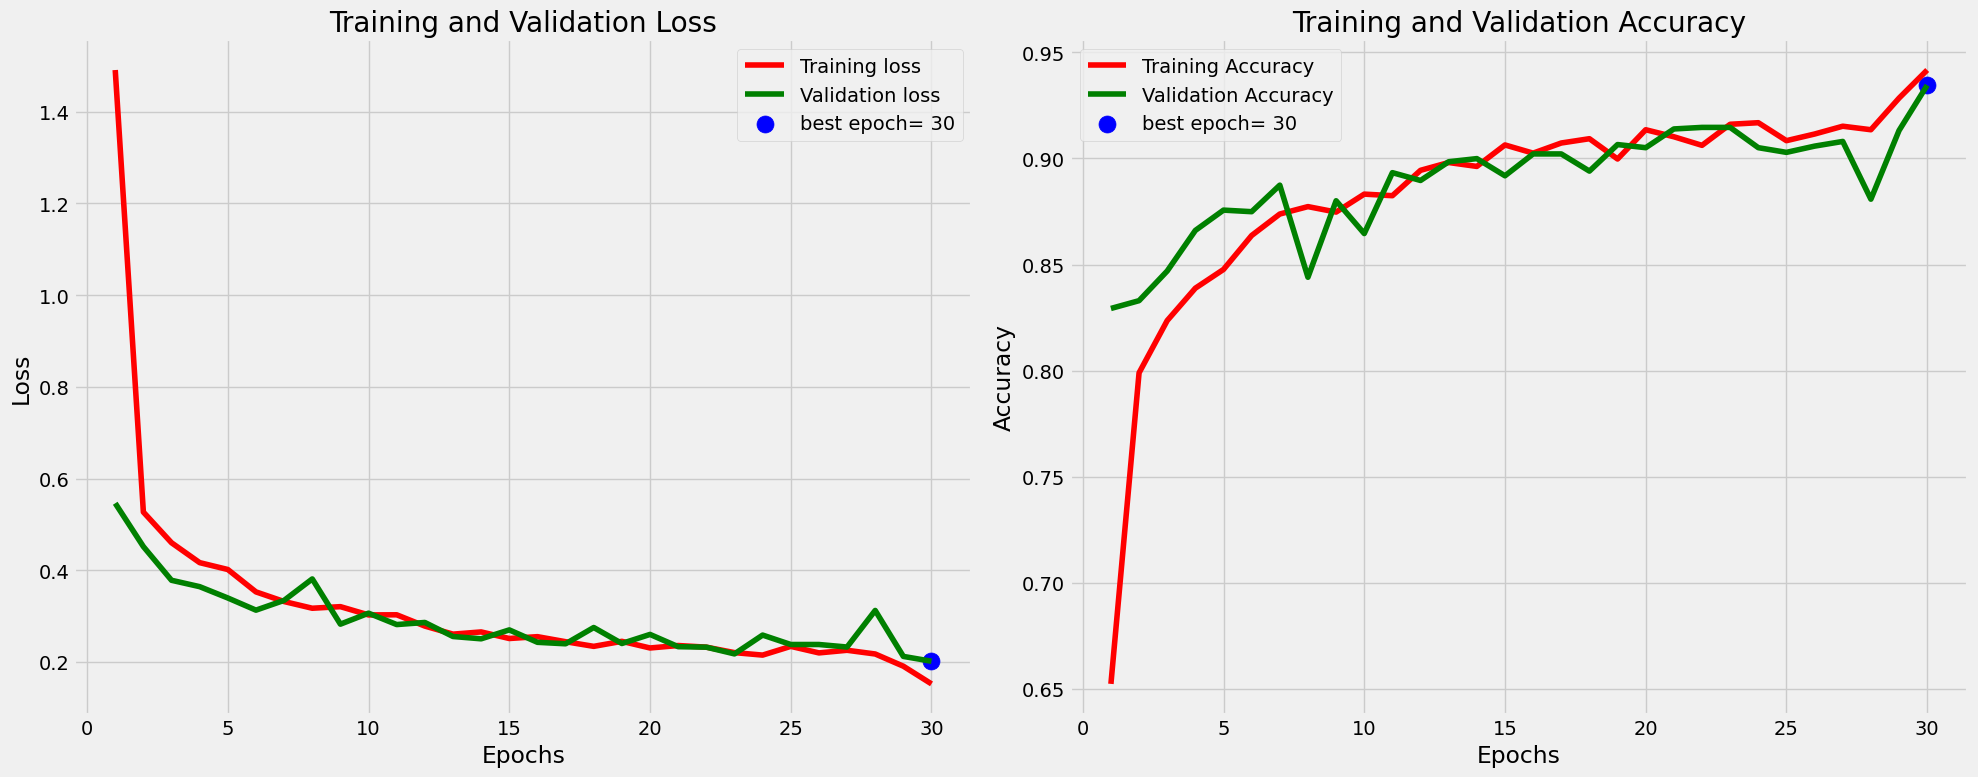

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 381ms/step - accuracy: 0.9339 - loss: 0.1917
Validation loss: 0.2020445019006729, Validation accuracy: 0.9345106482505798
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 407ms/step
Classification Report for Fold 1
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       332
           1       0.82      0.89      0.85       277
           2       0.97      0.99      0.98       401
           3       0.98      0.96      0.97       349

    accuracy                           0.93      1359
   macro avg       0.93      0.93      0.93      1359
weighted avg       0.94      0.93      0.93      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step


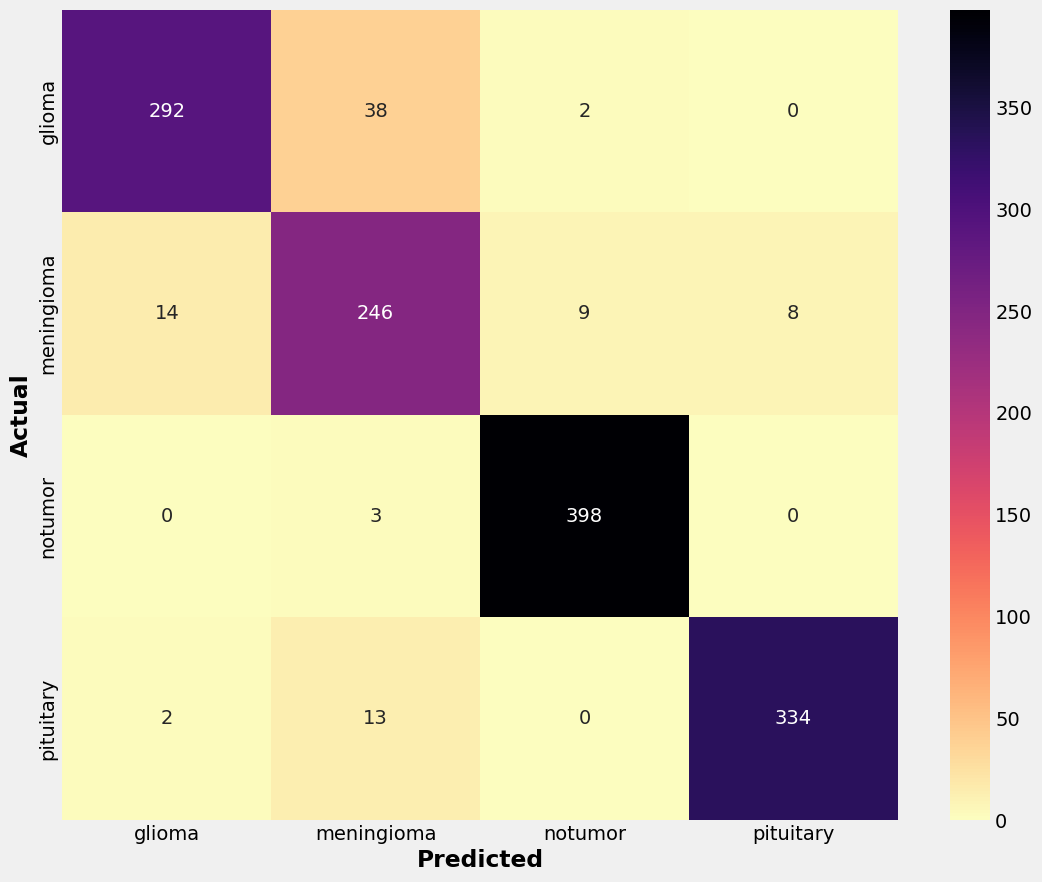

Fold 2/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 956ms/step - accuracy: 0.9334 - loss: 0.1765 - val_accuracy: 0.9581 - val_loss: 0.1177 - learning_rate: 5.0000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.9413 - loss: 0.1536 - val_accuracy: 0.9595 - val_loss: 0.1074 - learning_rate: 5.0000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 943ms/step - accuracy: 0.9313 - loss: 0.1691 - val_accuracy: 0.9581 - val_loss: 0.1168 - learning_rate: 5.0000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 943ms/step - accuracy: 0.9380 - loss: 0.1730 - val_accuracy: 0.9448 - val_loss: 0.1293 - learning_rate: 5.0000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 943ms/step - accuracy: 0.9398 - loss: 0.1539 - val_accuracy: 0.9625 - val_loss: 0.1019 - learning_rate: 5.0000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 956ms/step - accuracy: 0.9458 - loss: 0.1455 - val_accuracy: 0.9558 - val_loss: 0.1169 - learning_rate: 5.0000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 953ms/s

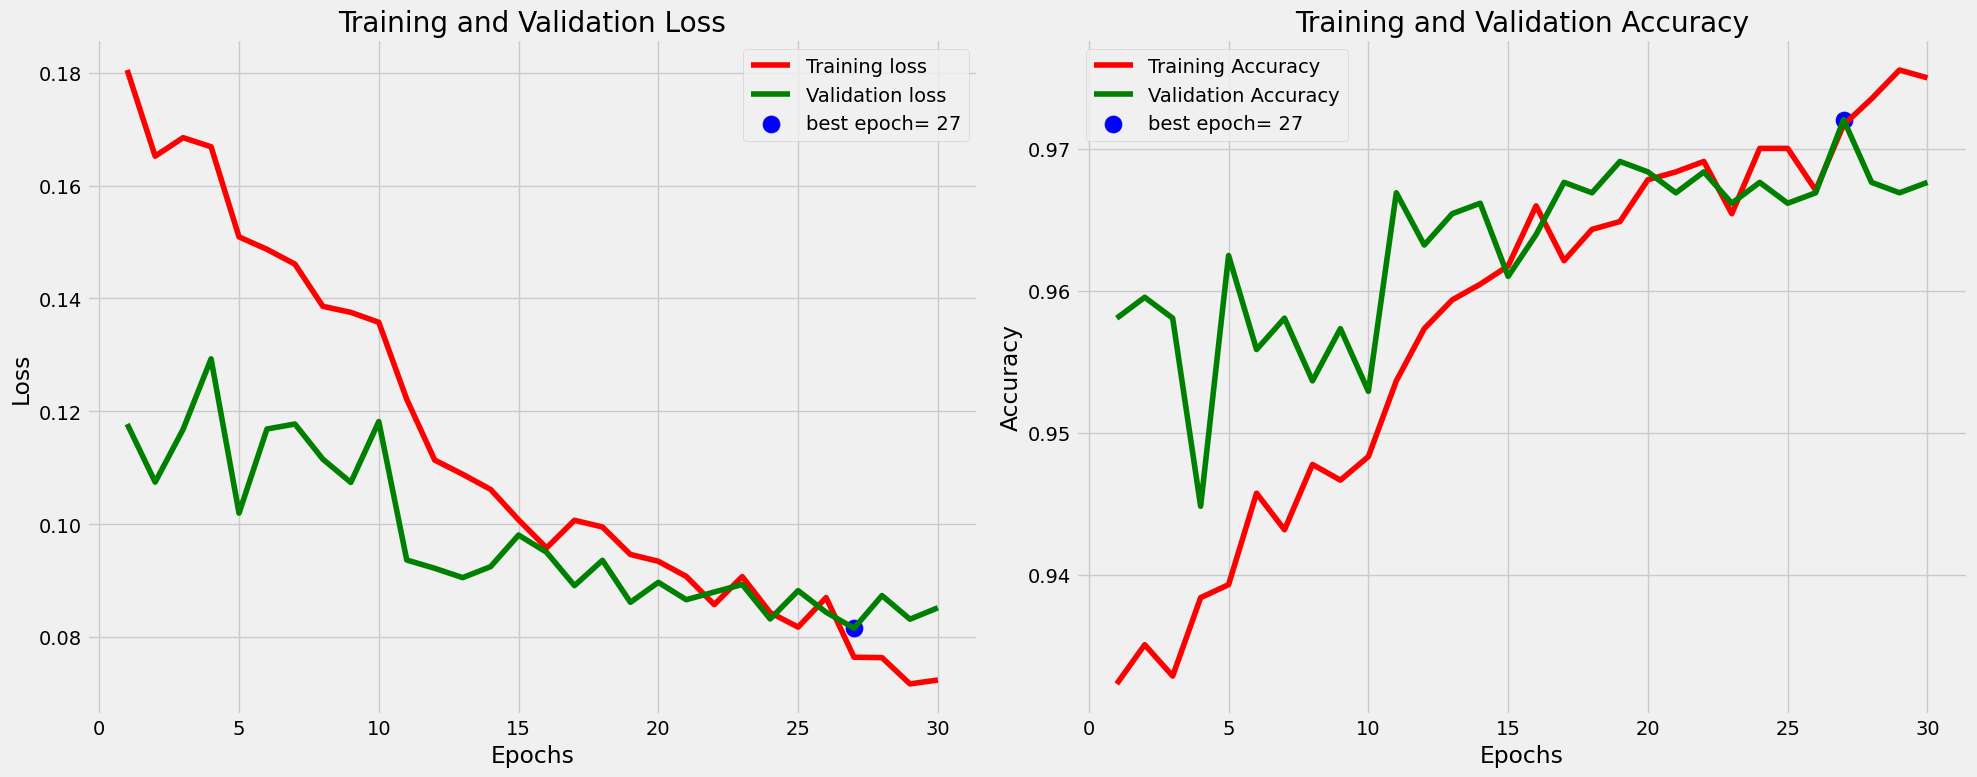

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - accuracy: 0.9770 - loss: 0.0724
Validation loss: 0.08256056159734726, Validation accuracy: 0.9720382690429688
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step
Classification Report for Fold 2
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       330
           1       0.93      0.94      0.94       284
           2       0.99      1.00      1.00       391
           3       0.99      0.98      0.98       354

    accuracy                           0.97      1359
   macro avg       0.97      0.97      0.97      1359
weighted avg       0.97      0.97      0.97      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 367ms/step


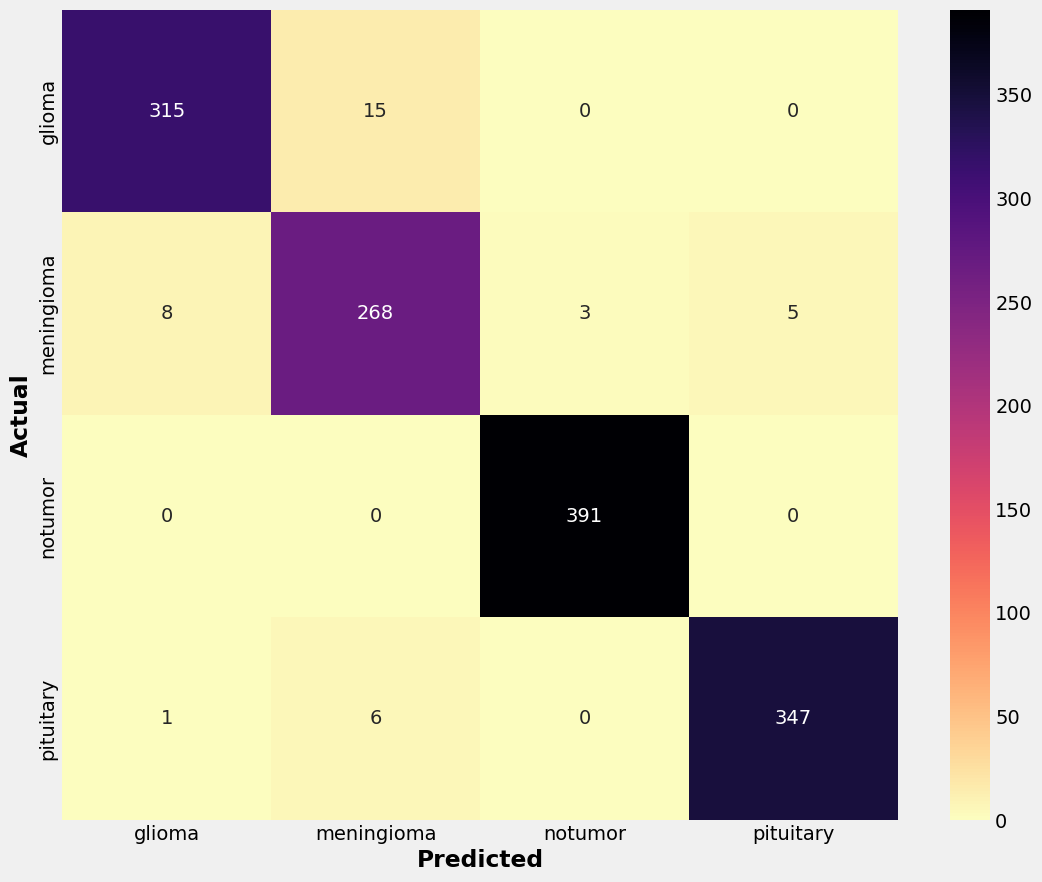

Fold 3/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 951ms/step - accuracy: 0.9658 - loss: 0.0947 - val_accuracy: 0.9809 - val_loss: 0.0542 - learning_rate: 2.5000e-04
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 950ms/step - accuracy: 0.9721 - loss: 0.0875 - val_accuracy: 0.9794 - val_loss: 0.0510 - learning_rate: 2.5000e-04
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 949ms/step - accuracy: 0.9705 - loss: 0.0818 - val_accuracy: 0.9765 - val_loss: 0.0605 - learning_rate: 2.5000e-04
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 950ms/step - accuracy: 0.9696 - loss: 0.0903 - val_accuracy: 0.9801 - val_loss: 0.0519 - learning_rate: 2.5000e-04
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 947ms/step - accuracy: 0.9728 - loss: 0.0785 - val_accuracy: 0.9838 - val_loss: 0.0512 - learning_rate: 2.5000e-04
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 949ms/step - accuracy: 0.9654 - loss: 0.0893 - val_accuracy: 0.9860 - val_loss: 0.0492 - learning_rate: 2.5000e-04
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 946ms/s

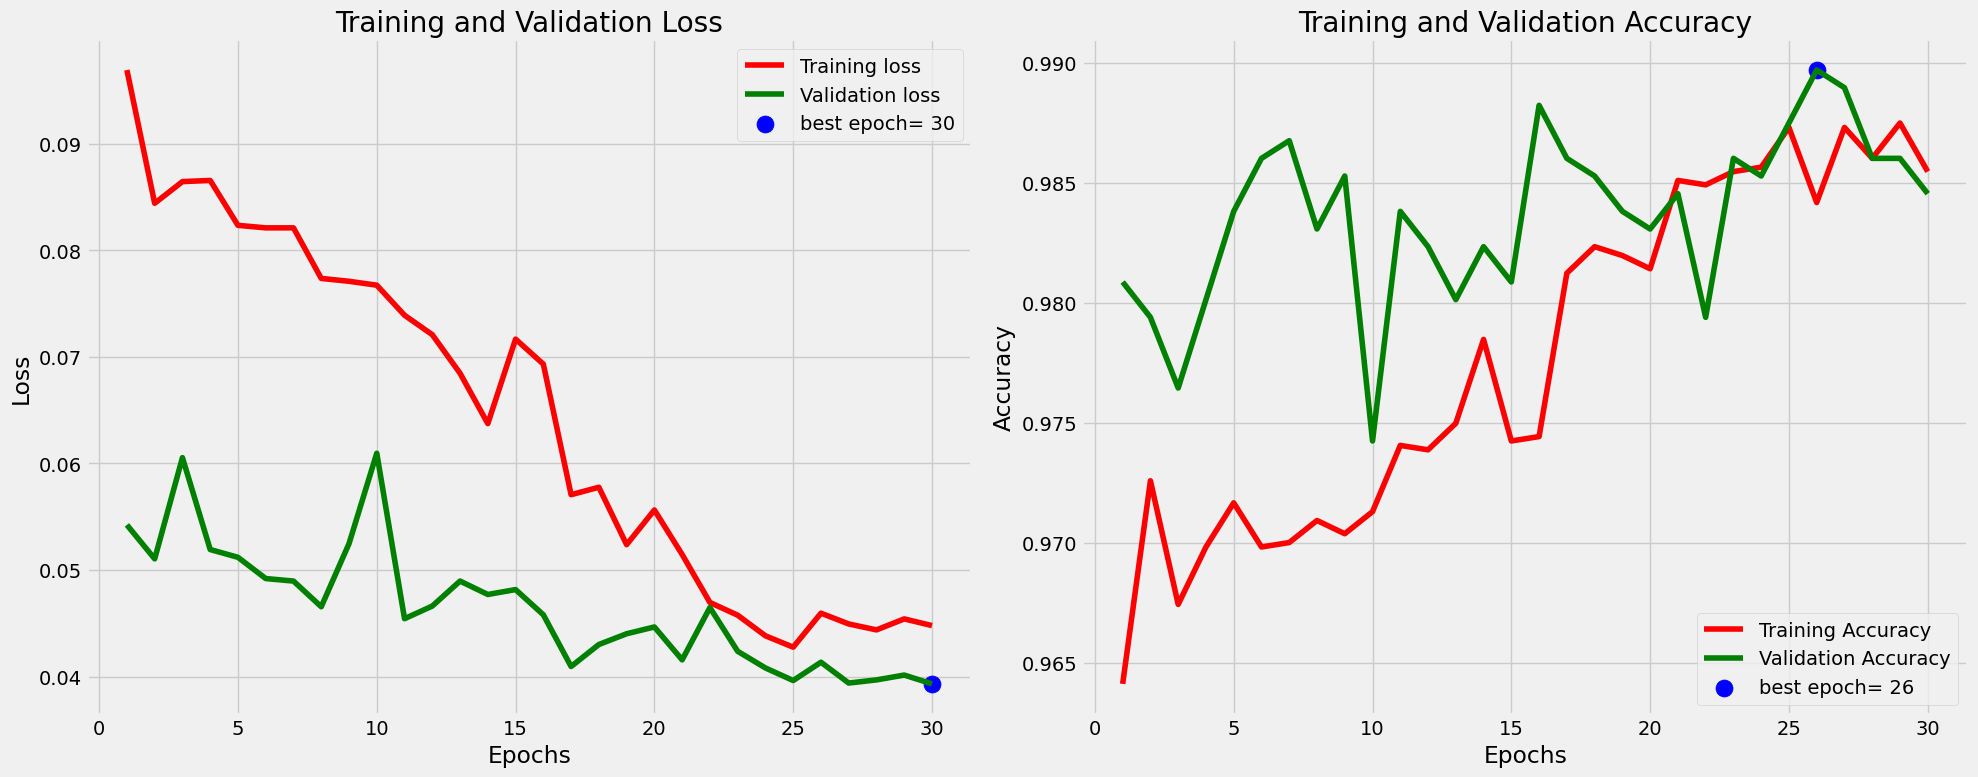

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step - accuracy: 0.9820 - loss: 0.0442
Validation loss: 0.0395682230591774, Validation accuracy: 0.9845474362373352
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step
Classification Report for Fold 3
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       326
           1       0.97      0.96      0.96       287
           2       1.00      1.00      1.00       415
           3       0.99      0.99      0.99       331

    accuracy                           0.98      1359
   macro avg       0.98      0.98      0.98      1359
weighted avg       0.98      0.98      0.98      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step


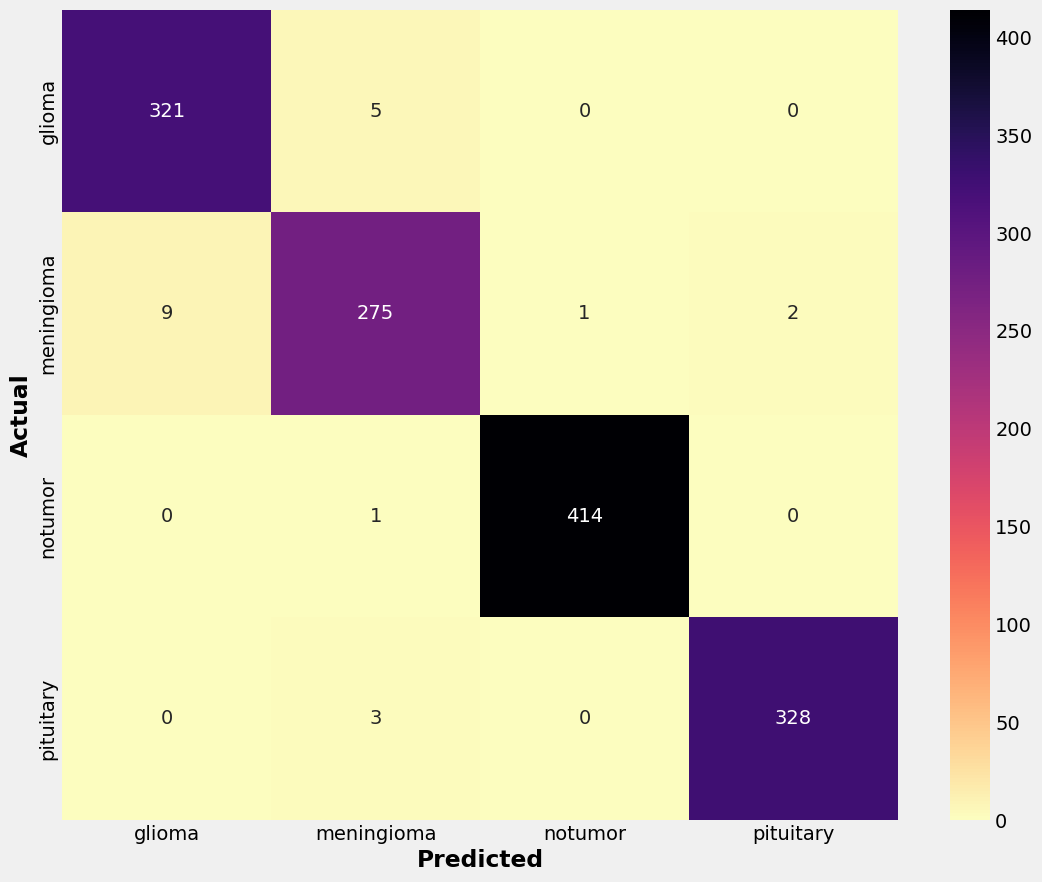

Fold 4/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 940ms/step - accuracy: 0.9832 - loss: 0.0502 - val_accuracy: 1.0000 - val_loss: 0.0163 - learning_rate: 6.2500e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 944ms/step - accuracy: 0.9855 - loss: 0.0460 - val_accuracy: 0.9978 - val_loss: 0.0185 - learning_rate: 6.2500e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.9853 - loss: 0.0489 - val_accuracy: 0.9993 - val_loss: 0.0163 - learning_rate: 6.2500e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 943ms/step - accuracy: 0.9850 - loss: 0.0491 - val_accuracy: 0.9993 - val_loss: 0.0164 - learning_rate: 6.2500e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 942ms/step - accuracy: 0.9833 - loss: 0.0520 - val_accuracy: 1.0000 - val_loss: 0.0169 - learning_rate: 6.2500e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 943ms/step - accuracy: 0.9838 - loss: 0.0509 - val_accuracy: 0.9985 - val_loss: 0.0170 - learning_rate: 6.2500e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 944ms/s

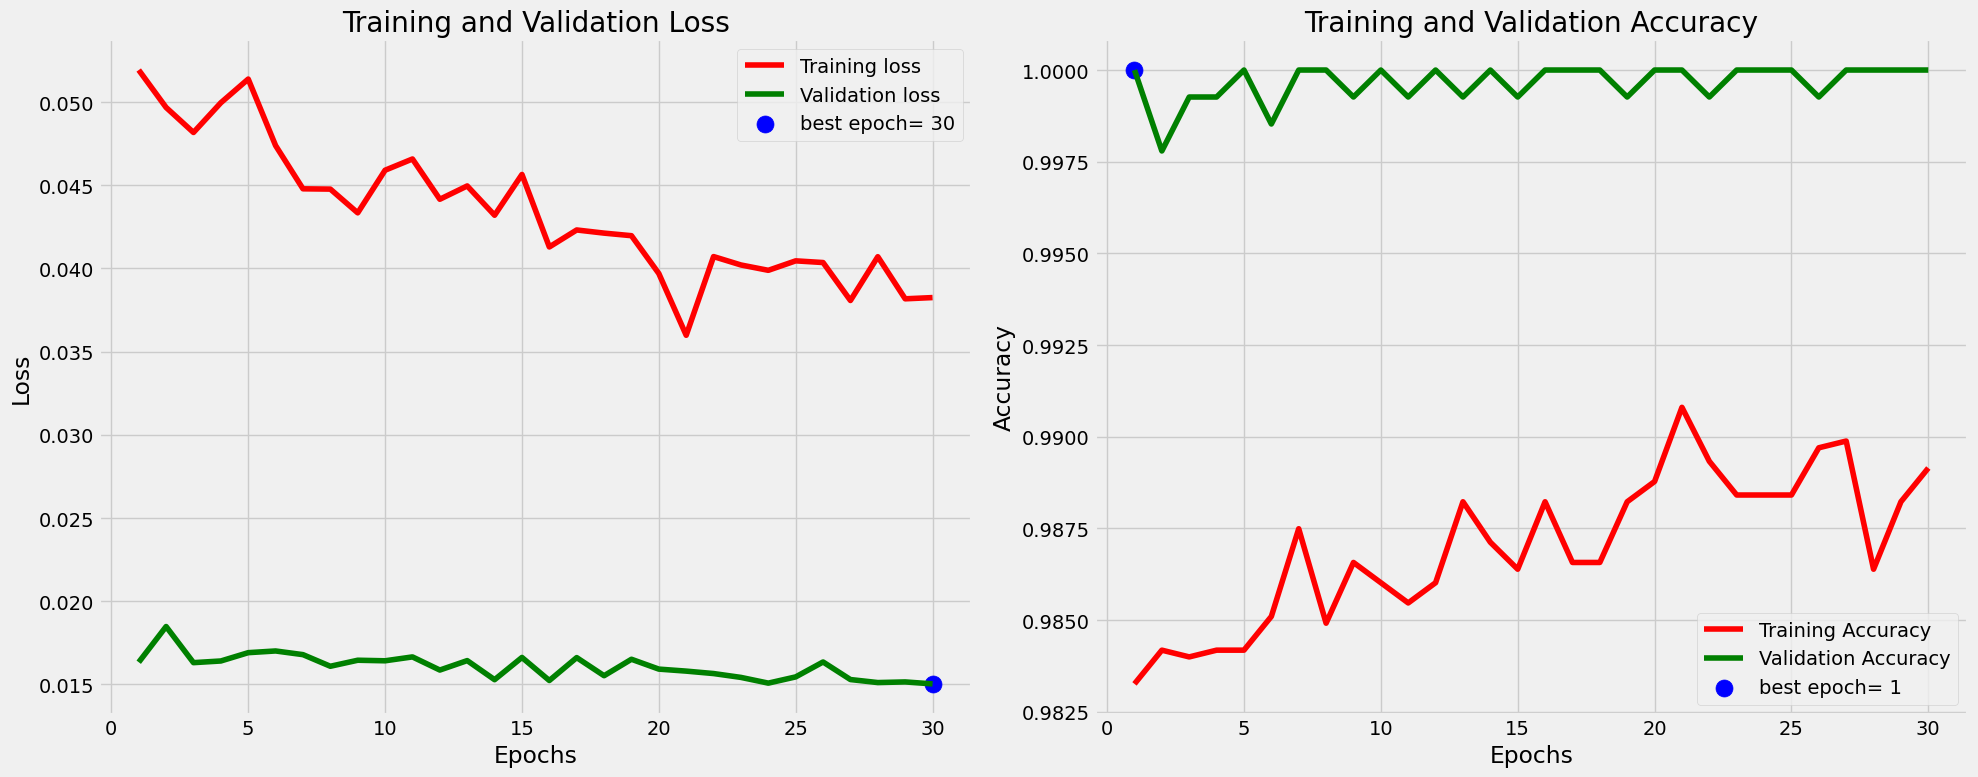

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 1.0000 - loss: 0.0136
Validation loss: 0.014755882322788239, Validation accuracy: 1.0
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step
Classification Report for Fold 4
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       326
           1       1.00      1.00      1.00       284
           2       1.00      1.00      1.00       374
           3       1.00      1.00      1.00       375

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step


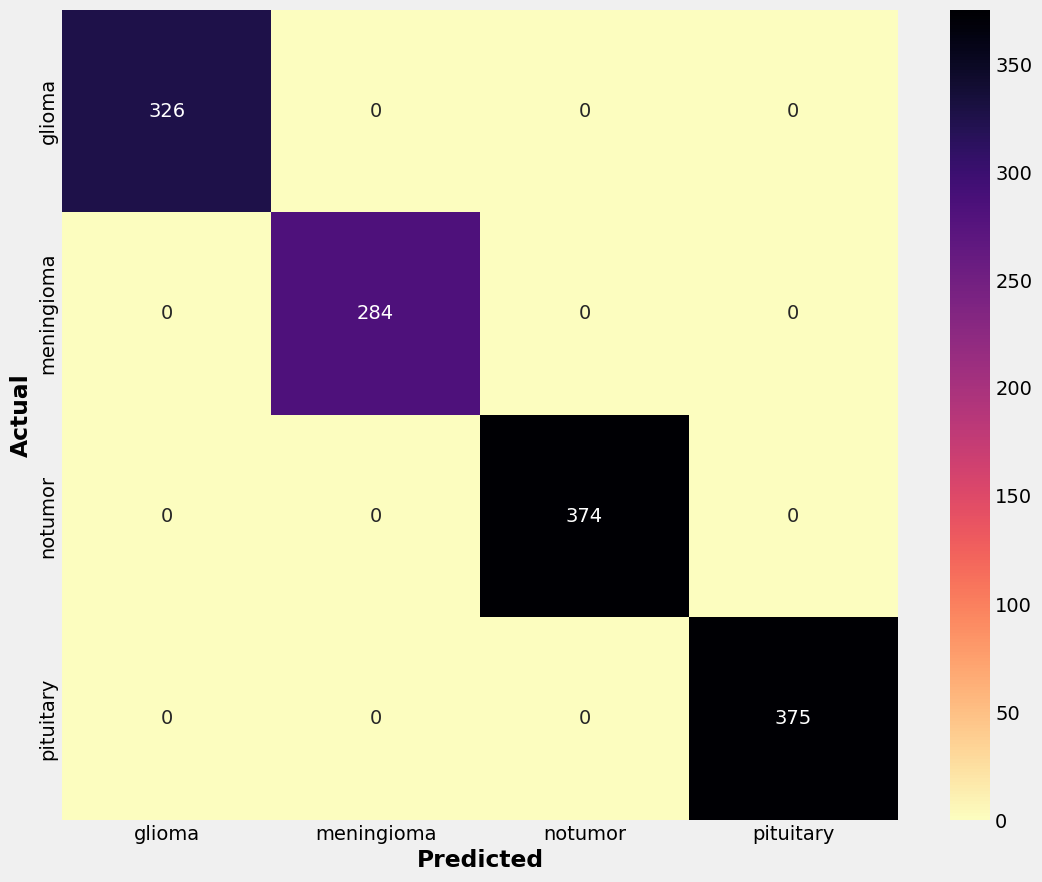

Fold 5/5
Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 939ms/step - accuracy: 0.9865 - loss: 0.0406 - val_accuracy: 0.9985 - val_loss: 0.0157 - learning_rate: 1.0000e-05
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 947ms/step - accuracy: 0.9885 - loss: 0.0365 - val_accuracy: 0.9985 - val_loss: 0.0151 - learning_rate: 1.0000e-05
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 948ms/step - accuracy: 0.9875 - loss: 0.0376 - val_accuracy: 0.9985 - val_loss: 0.0157 - learning_rate: 1.0000e-05
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 948ms/step - accuracy: 0.9887 - loss: 0.0410 - val_accuracy: 0.9985 - val_loss: 0.0155 - learning_rate: 1.0000e-05
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.9895 - loss: 0.0378 - val_accuracy: 0.9985 - val_loss: 0.0153 - learning_rate: 1.0000e-05
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 945ms/step - accuracy: 0.9873 - loss: 0.0411 - val_accuracy: 0.9985 - val_loss: 0.0153 - learning_rate: 1.0000e-05
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 80s 947ms/s

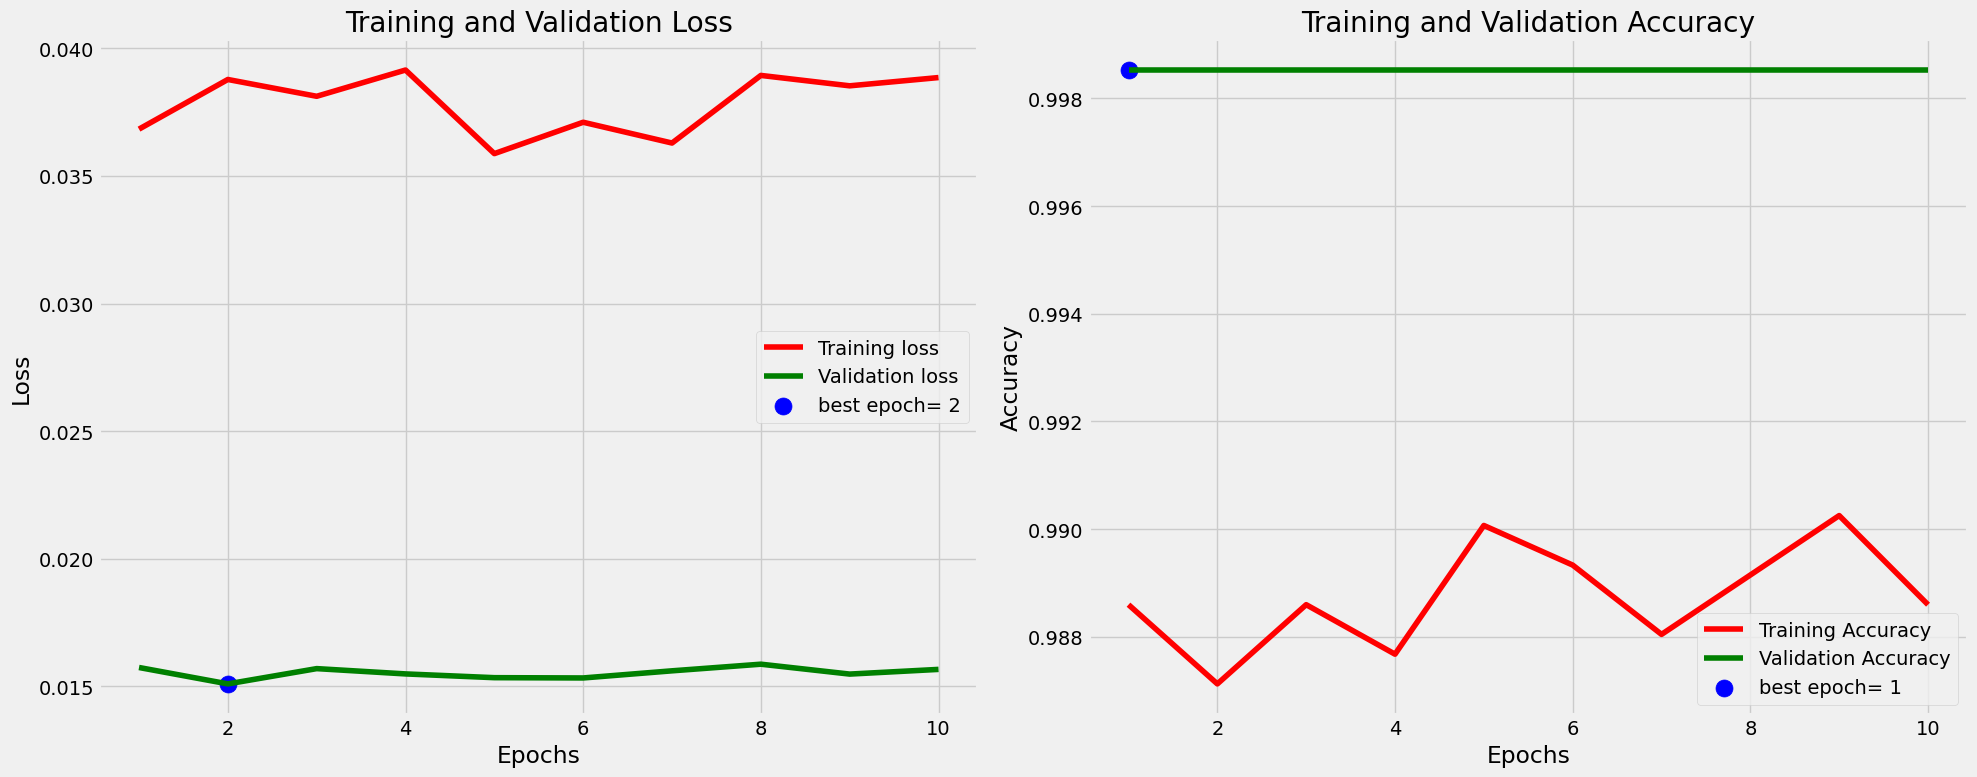

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step - accuracy: 0.9991 - loss: 0.0138
Validation loss: 0.01583971455693245, Validation accuracy: 0.9985283017158508
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step
Classification Report for Fold 5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 362ms/step


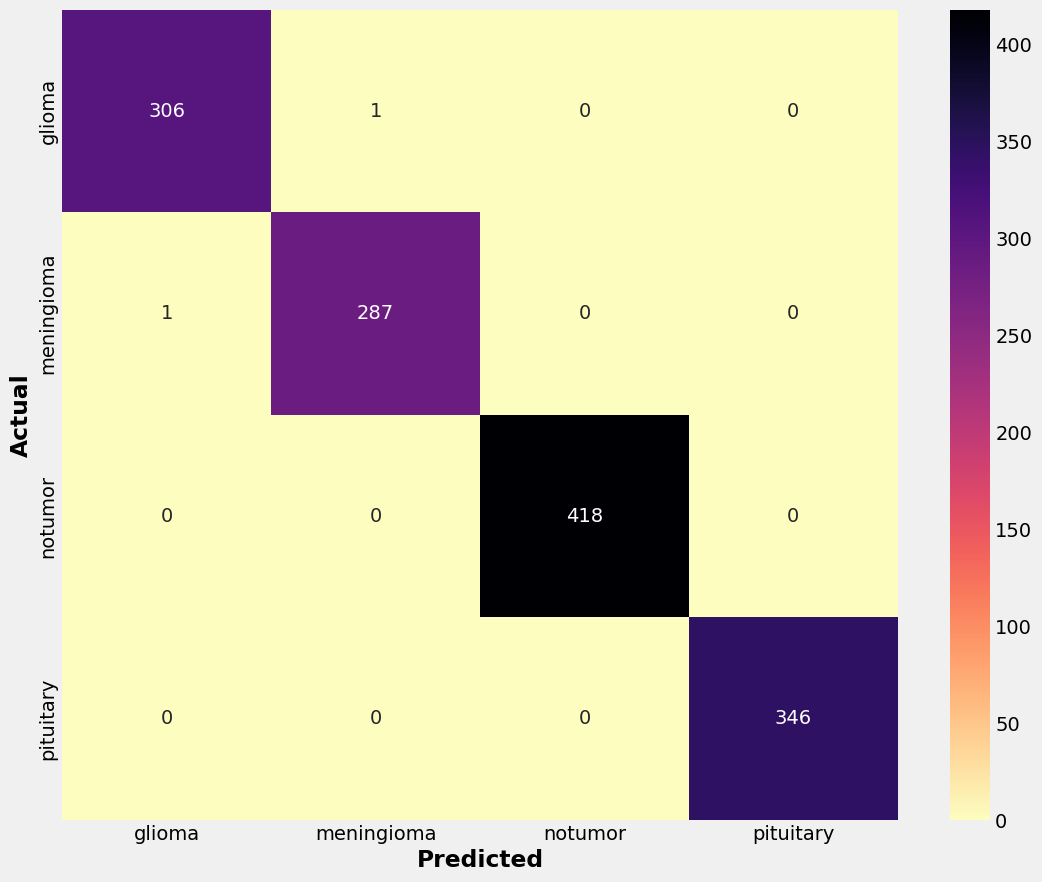

Total runtime of model: 178.92941089868546 Seconds


In [41]:
starting_time = time.time()   

# Define the number of folds for cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds) 

# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_train_1)):
    print(f"Fold {fold + 1}/{num_folds}")
    X_train_fold, X_val_fold = X_train_1[train_index], X_train_1[val_index]
    y_train_fold, y_val_fold = y_train_one_encoded_1[train_index], y_train_one_encoded_1[val_index]

    # Train the model on this fold
    history_DenseNet121 = model_DenseNet121.fit(X_train_fold, y_train_fold, epochs=30, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping, reduce_lr] )

    visualize_2(history_DenseNet121)
    
    # Evaluate the model on the validation fold
    scores = model_DenseNet121.evaluate(X_val_fold, y_val_fold)
    print(f"Validation loss: {scores[0]}, Validation accuracy: {scores[1]}") 
    
    
    # Generate predictions for the validation fold
    fold_predictions_3 = np.argmax(model_DenseNet121.predict(X_val_fold), axis=-1)
    fold_true_labels_3 = np.argmax(y_val_fold, axis=-1)
    
    # Generate and print classification report for this fold
    fold_classification_report = classification_report(fold_true_labels_3, fold_predictions_3)
    print("Classification Report for Fold", fold + 1)
    print(fold_classification_report) 
    y_pred = model_DenseNet121.predict(X_val_fold)  # X_test_normalized
    y_pred = np.argmax(y_pred,axis=1)  
    y_test_new = np.argmax(y_val_fold,axis=1) 

    conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted', fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.show() 
    
    
ending_time = time.time()    

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Seconds") 

In [42]:
val_loss, val_acc = model_DenseNet121.evaluate(X_val_fold, y_val_fold)
print("Test Accuracy: {:.2f}%".format(val_acc * 100)) 
print("Test Loss: {:.2f}%".format(val_loss * 100))

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.9991 - loss: 0.0138
Test Accuracy: 99.85%
Test Loss: 1.58%


In [43]:
y_pred = model_DenseNet121.predict(X_val_fold)
y_pred = np.argmax(y_pred,axis=1)

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step


In [44]:
y_test_new = np.argmax(y_val_fold,axis=1)

In [45]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

    accuracy                           1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359



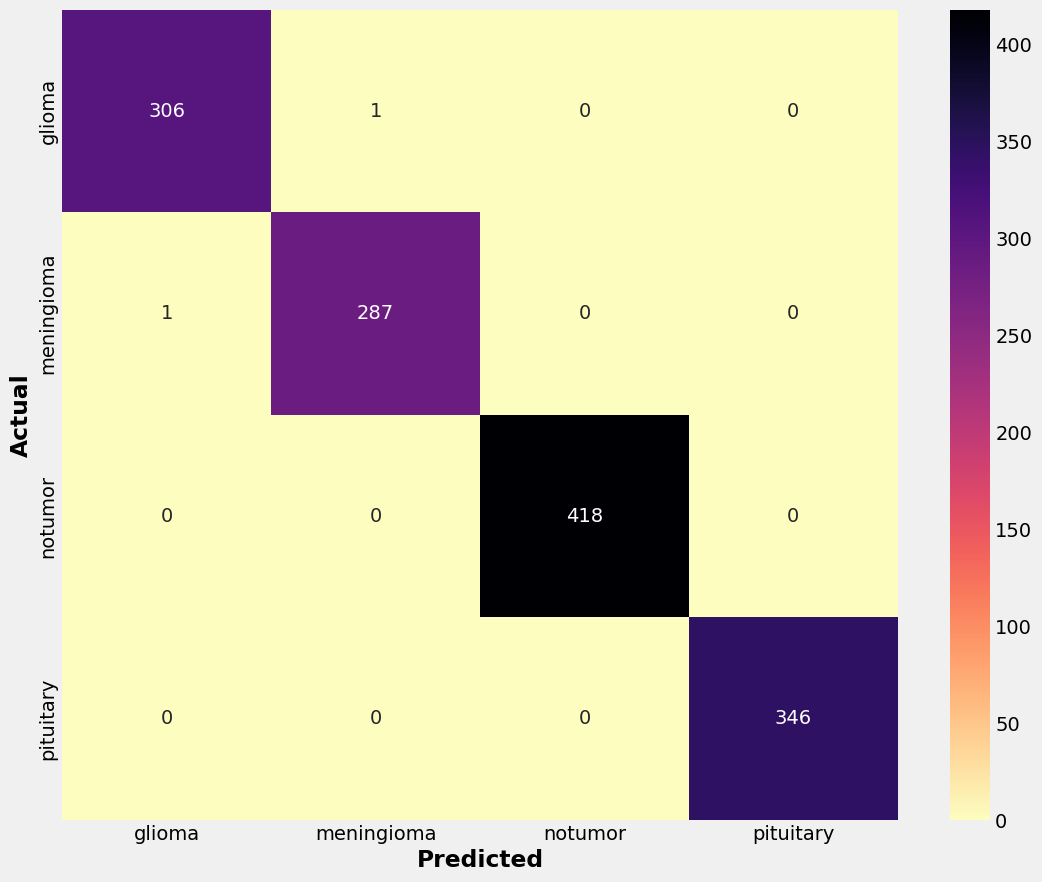

In [46]:
conf_matrix = confusion_matrix(y_test_new,y_pred) # x=y_test_new, y=y_pred

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.show() 

In [47]:
# saving the model 
save_model(model_DenseNet121, 'saved_model_DenseNet121_5K_Lastone.keras')  

In [48]:
# Loading model 
model_modelDenseNet121 = load_model('saved_model_DenseNet121_5K_Lastone.keras')

c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 734 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [49]:
second_last_layer_output = model_modelDenseNet121.layers[-2].output

feature_extractor_3 = Model(inputs=model_modelDenseNet121.input, outputs=second_last_layer_output)  

# feature_extractor_3.summary()

In [50]:
extracted_feature_DenseNet121_Training = feature_extractor_3.predict(X_train_fold)

170/170 ━━━━━━━━━━━━━━━━━━━━ 65s 372ms/step


In [51]:
extracted_feature_DenseNet121_Training.shape

(5436, 1024)

In [52]:
extracted_feature_DenseNet121_Testing = feature_extractor_3.predict(X_val_fold)

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 365ms/step


In [53]:
extracted_feature_DenseNet121_Testing.shape

(1359, 1024)

## Feature Extraction

In [54]:
## X_train
print(extracted_feature_Xception_Training.shape) 
print(extracted_feature_InceptionV3_Training.shape) 
print(extracted_feature_DenseNet121_Training.shape) 
print('///////////////////////////////////')
#X_test 
print(extracted_feature_Xception_Testing.shape) 
print(extracted_feature_InceptionV3_Testing.shape) 
print(extracted_feature_DenseNet121_Testing.shape) 

(5436, 1024)
(5436, 1024)
(5436, 1024)
///////////////////////////////////
(1359, 1024)
(1359, 1024)
(1359, 1024)


In [55]:
concatenated_features_Training = np.concatenate((extracted_feature_Xception_Training, 
                                        extracted_feature_InceptionV3_Training, 
                                        extracted_feature_DenseNet121_Training), axis=1)

# Check the shape of the concatenated features 
concatenated_features_Testing = np.concatenate((extracted_feature_Xception_Testing, 
                                        extracted_feature_InceptionV3_Testing, 
                                        extracted_feature_DenseNet121_Testing), axis=1)

print("Features Shape for training:", concatenated_features_Training.shape) 
print("Features Shape for testing:", concatenated_features_Testing.shape) 

Features Shape for training: (5436, 3072)
Features Shape for testing: (1359, 3072)


In [56]:
#Libraries 
#ML classifiers
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.multioutput import MultiOutputClassifier 
from sklearn.metrics import accuracy_score 

In [57]:
print("Shape of concatenated_features_Training:", concatenated_features_Training.shape)
print("Shape of y_train_fold:", y_train_fold.shape)
print("Shape of concatenated_features_Testing:", concatenated_features_Testing.shape)
print("Shape of y_val_fold:", y_val_fold.shape)

Shape of concatenated_features_Training: (5436, 3072)
Shape of y_train_fold: (5436, 4)
Shape of concatenated_features_Testing: (1359, 3072)
Shape of y_val_fold: (1359, 4)


## RF --------------------------------------------------------------

In [58]:
starting_time = time.time()   

random_forest_classifier = RandomForestClassifier(n_estimators=1000, max_depth=1000)  
random_forest_classifier.fit(concatenated_features_Training, y_train_fold)

# Evaluate Random Forest classifier
accuracy_RF = random_forest_classifier.score(concatenated_features_Testing, y_val_fold)
print("Accuracy of RF:", accuracy_RF)   

ending_time = time.time()   

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.") 

Accuracy of RF: 0.9941133186166299
Total runtime of model: 0.5772625168164571 Min.


In [59]:
# Predict the labels for the test set
y_pred_RF = random_forest_classifier.predict(concatenated_features_Testing)

# Generate the classification report
report = classification_report(y_val_fold, y_pred_RF)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       307
           1       0.99      0.99      0.99       288
           2       1.00      1.00      1.00       418
           3       1.00      1.00      1.00       346

   micro avg       1.00      0.99      1.00      1359
   macro avg       1.00      0.99      0.99      1359
weighted avg       1.00      0.99      1.00      1359
 samples avg       0.99      0.99      0.99      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


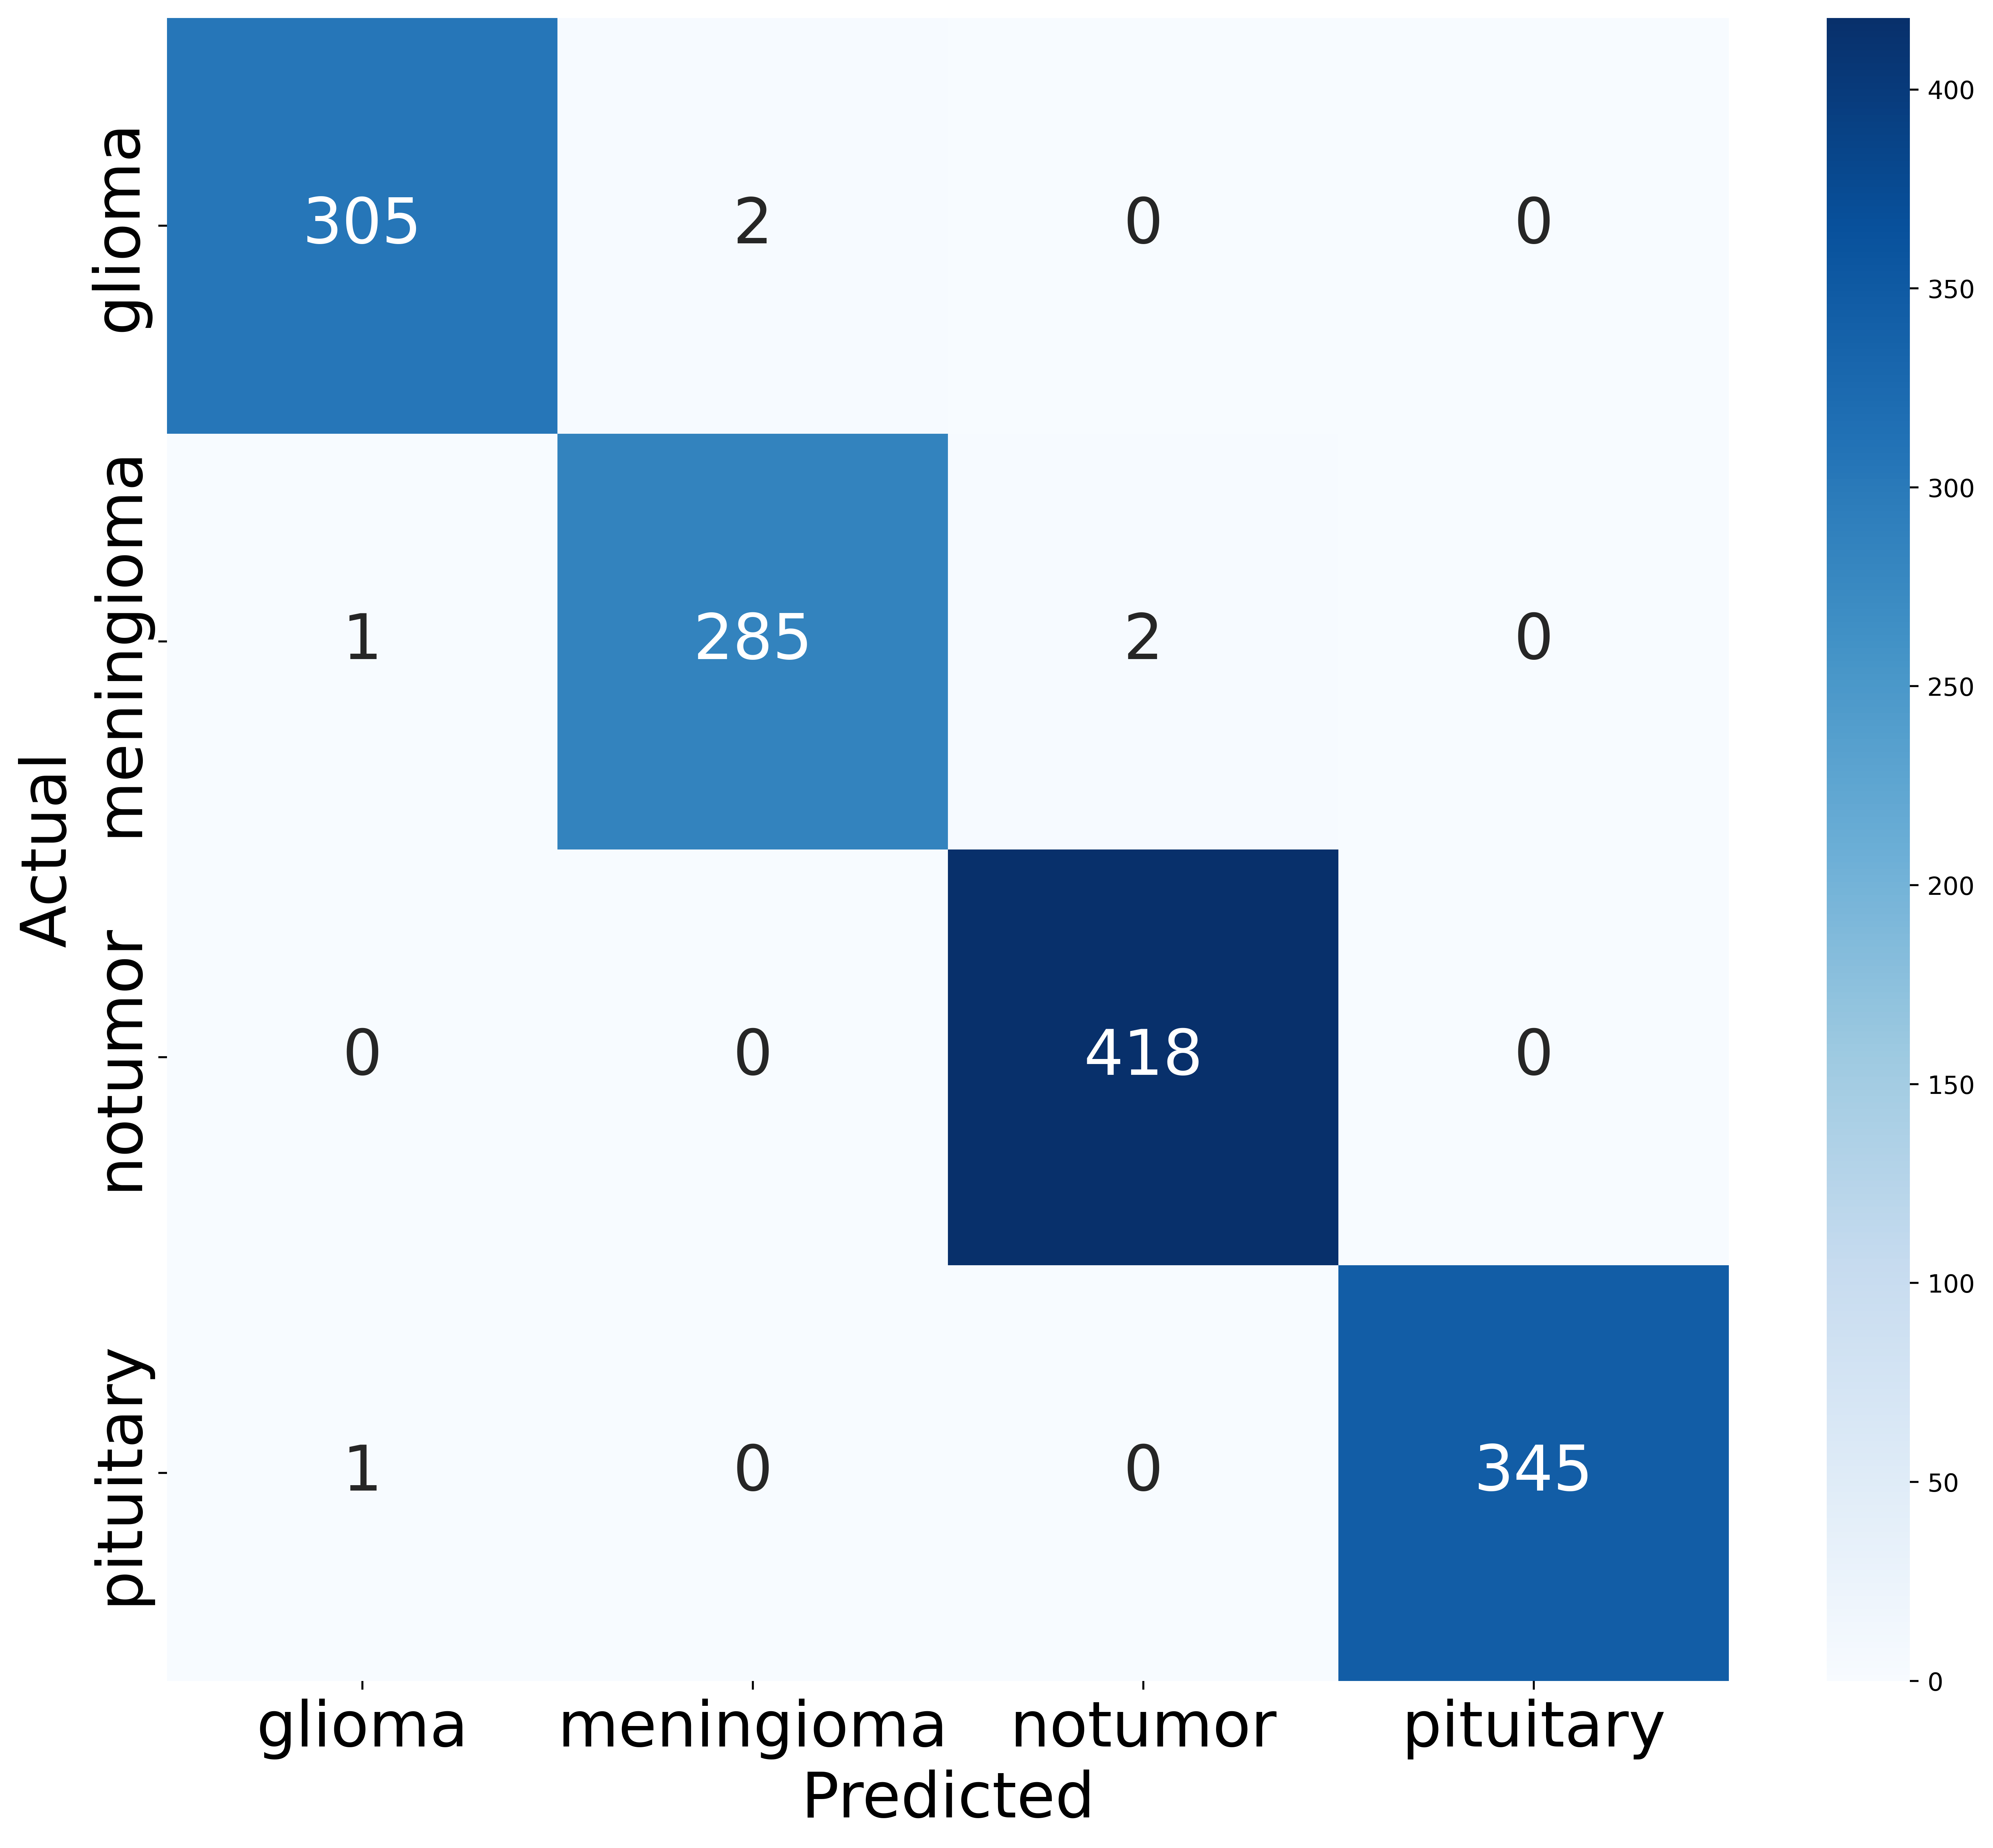

In [2]:
# Define class labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Define the confusion matrix data
confusion_matrix = np.array([[305,  2,   0,  0],
                            [  1, 285,  2,  0],
                            [  0,   0, 418,   0],
                            [  1,   0,   0, 345]])

# Plot confusion matrix
plt.figure(figsize=(14, 12), dpi=500)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 25})

# Increase label font size
plt.xticks(fontsize=25)
plt.yticks(fontsize=25) 
plt.xlabel('Predicted', fontsize = 25)
plt.ylabel('Actual', fontsize = 25)
plt.show()

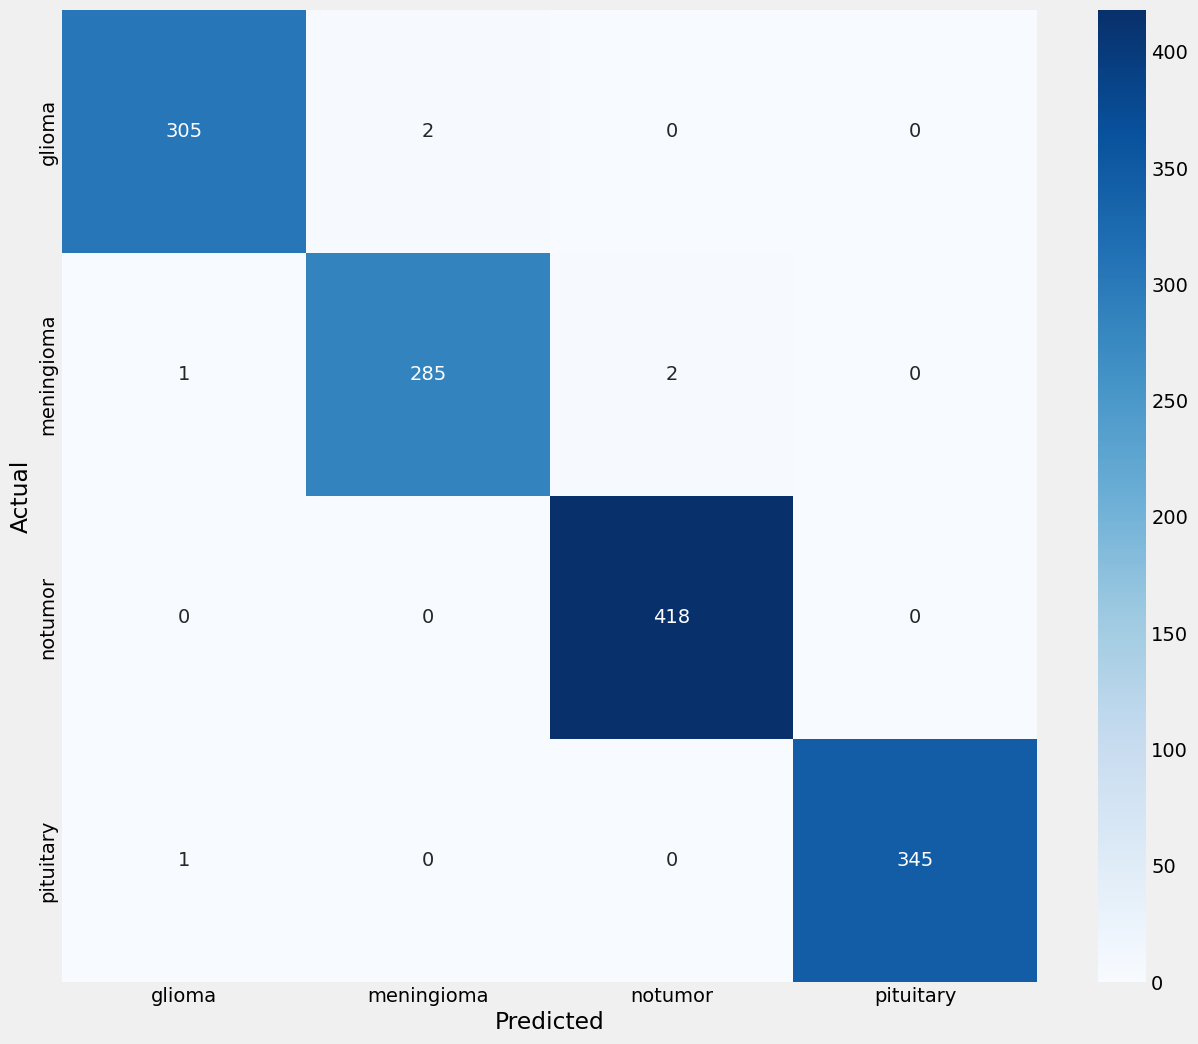

In [60]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_RF, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LR ---------------------------------------------------------------------

In [61]:
starting_time = time.time()    

# Train a multi-output logistic regression classifier
logistic_regression_classifier = LogisticRegression(multi_class="multinomial", max_iter=10000)
multi_output_classifier = MultiOutputClassifier(logistic_regression_classifier)
multi_output_classifier.fit(concatenated_features_Training, y_train_fold)

# Predict on the testing data
y_pred_LR = multi_output_classifier.predict(concatenated_features_Testing) 

# Calculate accuracy
accuracy_lr = accuracy_score(y_val_fold, y_pred_LR)
print("Accuracy of LR:", accuracy_lr) 

ending_time = time.time()  

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.")

Accuracy of LR: 0.9933774834437086
Total runtime of model: 0.03345708052317301 Min.


In [62]:
# Generate classification report
report = classification_report(y_val_fold, y_pred_LR, target_names=labels)
print(report)

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       307
  meningioma       0.99      0.99      0.99       288
     notumor       1.00      1.00      1.00       418
   pituitary       1.00      1.00      1.00       346

   micro avg       1.00      1.00      1.00      1359
   macro avg       1.00      1.00      1.00      1359
weighted avg       1.00      1.00      1.00      1359
 samples avg       1.00      1.00      1.00      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


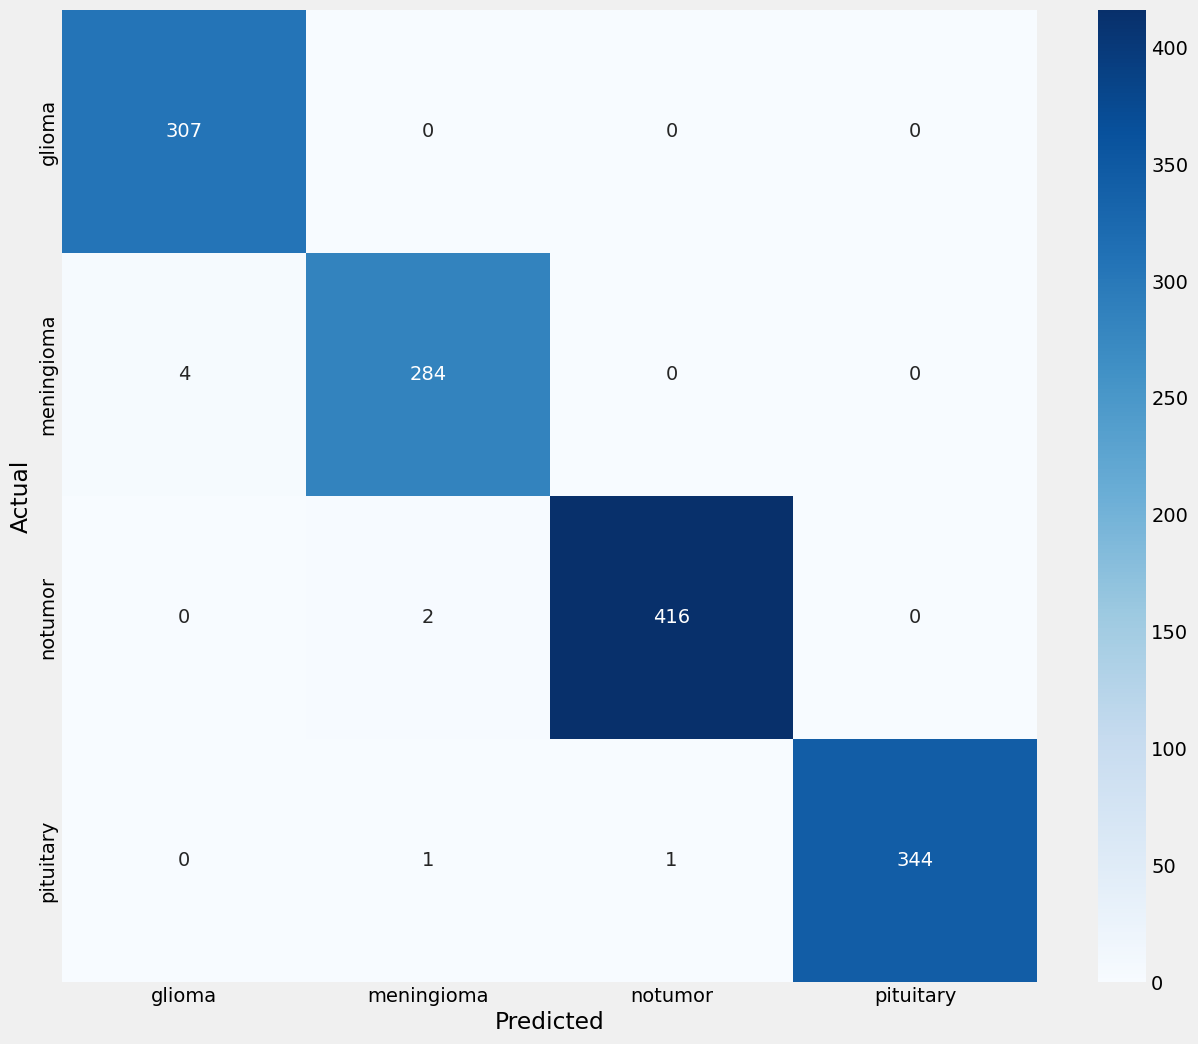

In [63]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_LR, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## KNN -------------------------------------------------------------

In [64]:
starting_time = time.time()   

knn_classifier = KNeighborsClassifier(n_neighbors=4)  
knn_classifier.fit(concatenated_features_Training, y_train_fold)

# Evaluate KNN classifier
accuracy_KNN = knn_classifier.score(concatenated_features_Testing, y_val_fold)
print("Accuracy of KNN:", accuracy_KNN) 

ending_time = time.time()  

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.")

Accuracy of KNN: 0.9492273730684326
Total runtime of model: 0.009200576941172283 Min.


In [65]:
# Predict the labels for the test set
y_pred_KNN = knn_classifier.predict(concatenated_features_Testing)

# Generate the classification report
report = classification_report(y_val_fold, y_pred_KNN)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       307
           1       0.98      0.88      0.92       288
           2       0.99      0.97      0.98       418
           3       0.99      0.99      0.99       346

   micro avg       0.98      0.95      0.97      1359
   macro avg       0.98      0.94      0.96      1359
weighted avg       0.98      0.95      0.97      1359
 samples avg       0.95      0.95      0.95      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


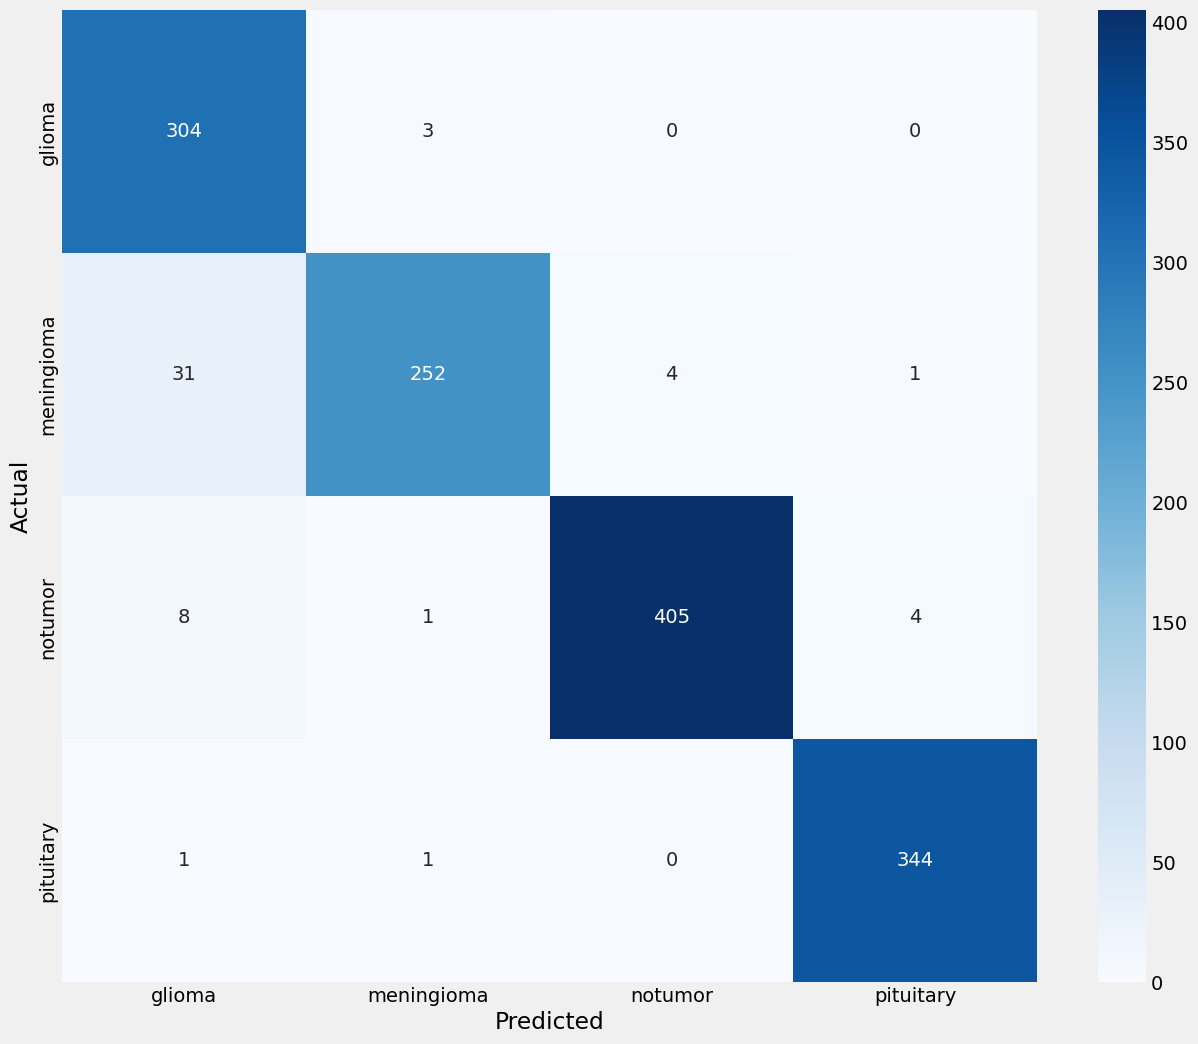

In [66]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_KNN, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVM -------------------------------------------------------------

In [67]:
# Before feature selection
starting_time = time.time()    

# Train a multi-output SVM classifier with linear kernel
svm_classifier = SVC(kernel='linear')
multi_output_classifier = MultiOutputClassifier(svm_classifier)
multi_output_classifier.fit(concatenated_features_Training, y_train_fold)

# Predict on the testing data
y_pred_SVM_L = multi_output_classifier.predict(concatenated_features_Testing) 

# Calculate accuracy
accuracy_svm = accuracy_score(y_val_fold, y_pred_SVM_L)
print("Accuracy of SVM:", accuracy_svm) 

ending_time = time.time()  

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.")


Accuracy of SVM: 0.9919058130978661
Total runtime of model: 0.09838898181915283 Min.


In [68]:
# Generate classification report 
report = classification_report(y_val_fold, y_pred_SVM_L, target_names=labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       307
  meningioma       0.98      0.99      0.98       288
     notumor       1.00      1.00      1.00       418
   pituitary       1.00      1.00      1.00       346

   micro avg       0.99      1.00      1.00      1359
   macro avg       0.99      1.00      1.00      1359
weighted avg       0.99      1.00      1.00      1359
 samples avg       0.99      1.00      1.00      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


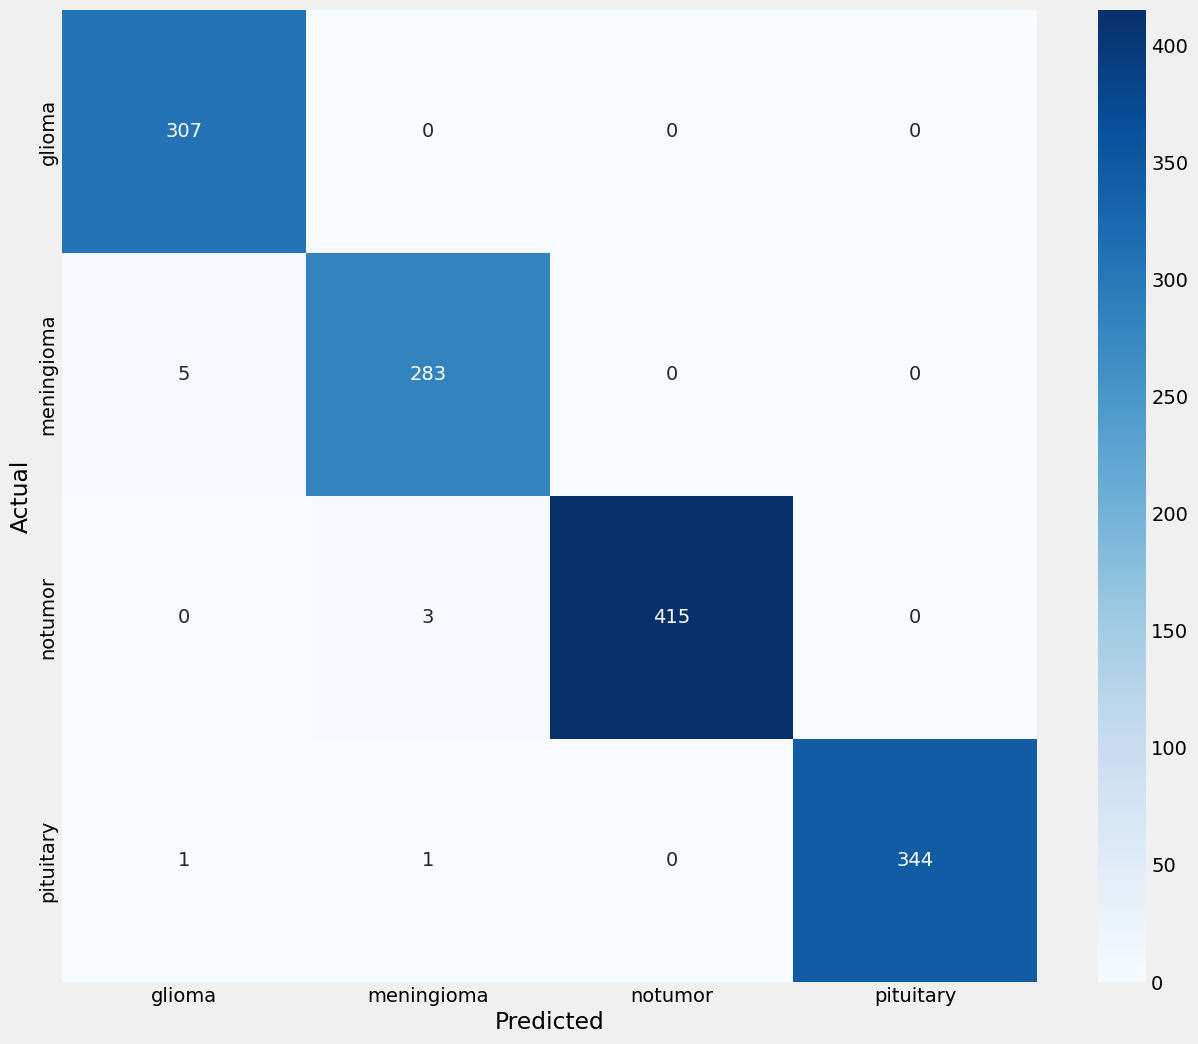

In [69]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_SVM_L, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVM -------------------------------------------------------------

In [70]:
starting_time = time.time()    

# Train a multi-output SVM classifier with linear kernel
svm_classifier = SVC(kernel='rbf')
multi_output_classifier = MultiOutputClassifier(svm_classifier)
multi_output_classifier.fit(concatenated_features_Training, y_train_fold)

# Predict on the testing data
y_pred_SVM_R = multi_output_classifier.predict(concatenated_features_Testing) 

# Calculate accuracy
accuracy_svm = accuracy_score(y_val_fold, y_pred_SVM_R)
print("Accuracy of SVM:", accuracy_svm) 

ending_time = time.time()  

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.")

Accuracy of SVM: 0.9941133186166299
Total runtime of model: 0.2950663129488627 Min.


In [71]:
# Generate classification report
report = classification_report(y_val_fold, y_pred_SVM_R, target_names=labels)
print(report)

              precision    recall  f1-score   support

      glioma       1.00      0.99      1.00       307
  meningioma       0.99      0.99      0.99       288
     notumor       1.00      1.00      1.00       418
   pituitary       1.00      1.00      1.00       346

   micro avg       1.00      0.99      1.00      1359
   macro avg       1.00      0.99      1.00      1359
weighted avg       1.00      0.99      1.00      1359
 samples avg       0.99      0.99      0.99      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


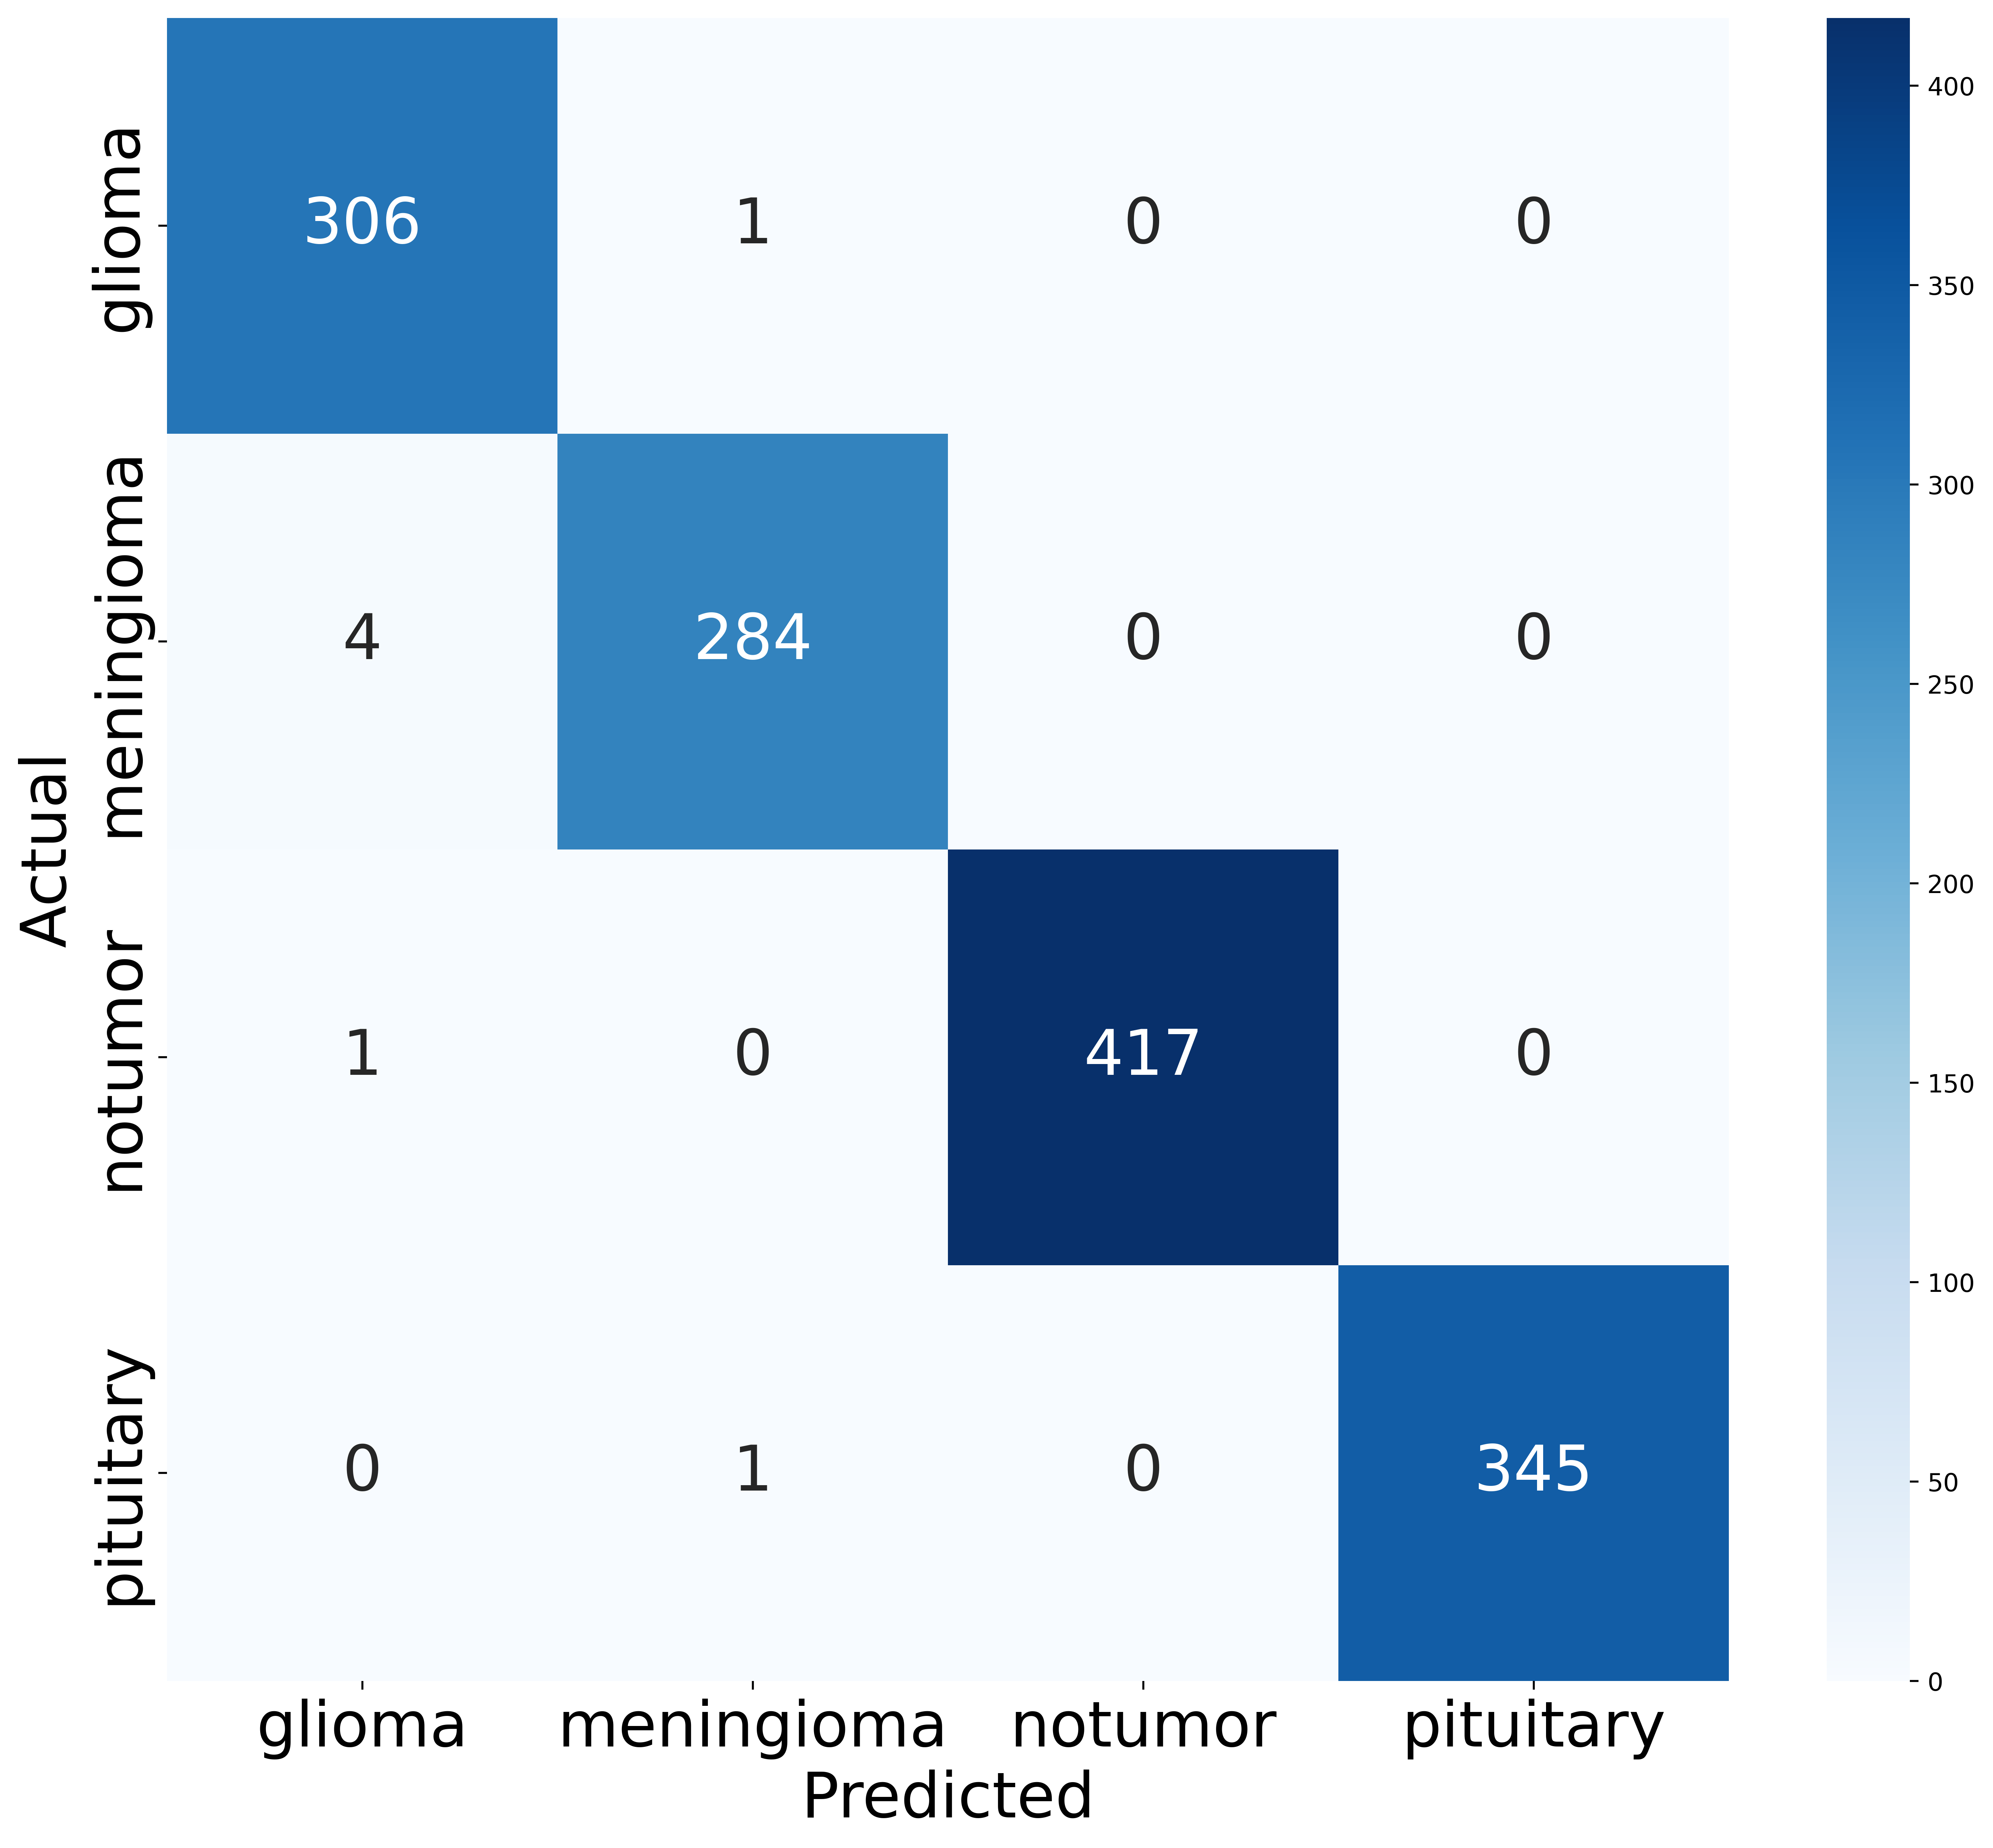

In [1]:
# Define class labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Define the confusion matrix data
confusion_matrix = np.array([[306,  1,   0,  0],
                            [  4, 284,  0,  0],
                            [  1,   0, 417,   0],
                            [  0,   1,   0, 345]])

# Plot confusion matrix
plt.figure(figsize=(14, 12), dpi=500)
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 25})

# Increase label font size
plt.xticks(fontsize=25)
plt.yticks(fontsize=25) 
plt.xlabel('Predicted', fontsize = 25)
plt.ylabel('Actual', fontsize = 25)
plt.show()

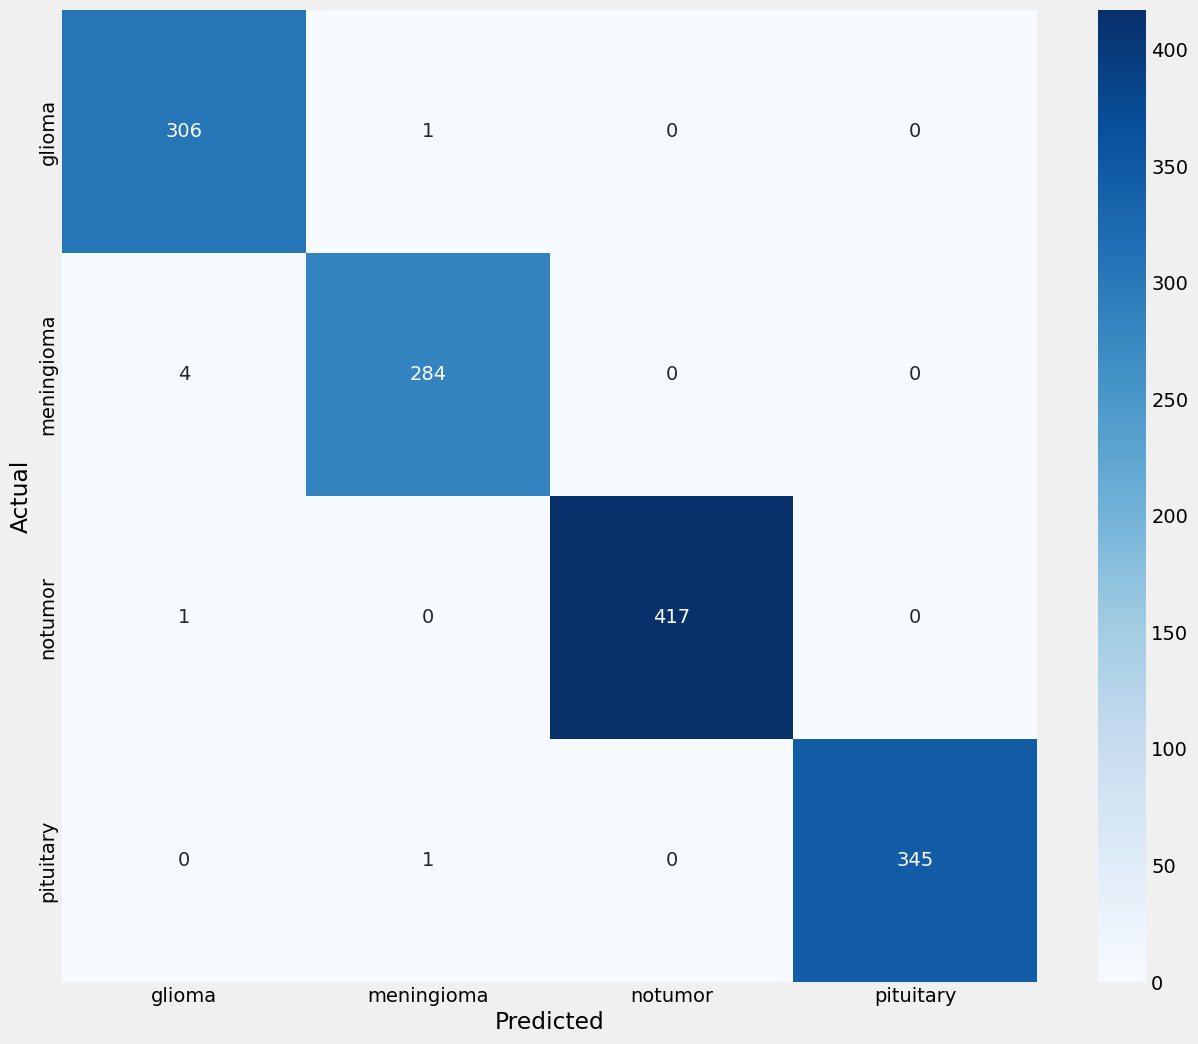

In [72]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_SVM_R, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## SVM --------------------------------------------------------------------------

In [73]:
starting_time = time.time()    

# Train a multi-output SVM classifier with linear kernel
svm_classifier = SVC(kernel='sigmoid')
multi_output_classifier = MultiOutputClassifier(svm_classifier)
multi_output_classifier.fit(concatenated_features_Training, y_train_fold)

# Predict on the testing data
y_pred_SVM_S = multi_output_classifier.predict(concatenated_features_Testing) 

# Calculate accuracy
accuracy_svm = accuracy_score(y_val_fold, y_pred_SVM_S)
print("Accuracy of SVM:", accuracy_svm) 

ending_time = time.time()  

total_run_time = ending_time - starting_time
print("Total runtime of model:", total_run_time/60, "Min.")

Accuracy of SVM: 0.7181751287711553
Total runtime of model: 0.3299312631289164 Min.


In [74]:
# Generate classification report
report = classification_report(y_val_fold, y_pred_SVM_S, target_names=labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.78      0.82      0.80       307
  meningioma       0.77      0.72      0.74       288
     notumor       0.89      0.82      0.85       418
   pituitary       0.79      0.84      0.81       346

   micro avg       0.81      0.80      0.81      1359
   macro avg       0.81      0.80      0.80      1359
weighted avg       0.81      0.80      0.81      1359
 samples avg       0.76      0.80      0.77      1359



c:\Users\Talha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


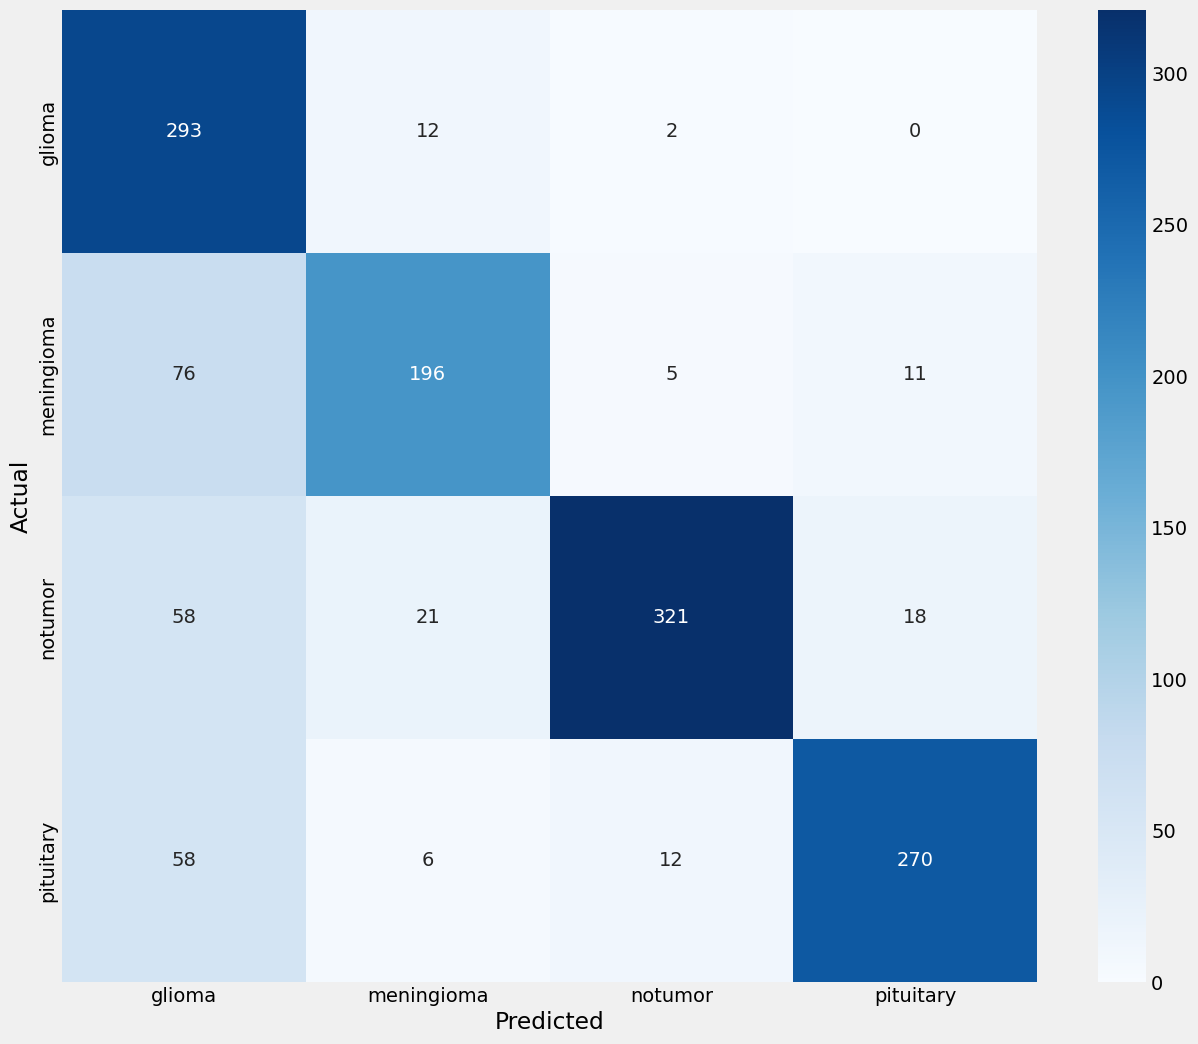

In [75]:
# Convert one-hot encoded labels to single-label indicators
y_val_single = np.argmax(y_val_fold, axis=1)
y_pred_single = np.argmax(y_pred_SVM_S, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val_single, y_pred_single)

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()